   <div class="alert alert-info" style="font-size: 26px;">
       <strong style="font-size: 26px;">Анализ аномалий в начислениях за тепловую энергию</strong>
   </div>

В процессе работы с аномальными начислениями потребителям тепловой энергии были выявлены случаи ошибочно внесённых показаний, а также случаи аномально низкого потребления тепловой энергии. Это привело к неправильным начислениям на общую сумму T млн рублей в пользу потребителя. Необходимо разработать и внедрить систему искусственного интеллекта (ИИ), которая будет анализировать данные о потреблении тепловой энергии и выявлять аномальные начисления. Система должна учитывать различные факторы, такие как показания приборов учёта, договорные нагрузки, погодные условия и другие параметры, которые могут повлиять на потребление тепловой энергии. Система ИИ должна автоматически обнаруживать аномалии в данных о потреблении и предоставлять информацию о них ответственным сотрудникам для дальнейшего анализа и принятия решений.

Виды аномалий по показаниям приборов учёта тепловой энергии, которые необходимо выявлять кроме объектов с видом энергопотребления ГВС (централ):

1. нулевые значения показаний за тепловую энергию в отопительный период (октябрь-апрель);
2. равные значения показаний в течение нескольких расчетных периодов;
3. снижение/рост показаний в отдельные месяцы по сравнению с показаниями за предыдущие периоды по данному объекту (с учётом фактической температуры наружного воздуха и количества отопительных дней в месяце);
4. аномально низкое/высокое (отклонение более 25%) потребление объекта в конкретном месяце по сравнению с аналогичными объектами (только для типов объекта «Многоквартирный дом») по критериям:
- год постройки (по группам до 1958 г., 1959-1989 гг., 1990-2000 гг., 2001-2010 гг., 2011-2024 гг.),
- этажность (по группам 1-2 этажа, 3-4 этажа, 5-9 этажей,10-12 этажей, 13 и более этажей),
- площадь (±10%),
- наличие ГВС ИТП (горячей воды, учитываемой тем же прибором).

# <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Импортируем необходимые библиотеки</div>

In [ ]:
# для запуска в colab
!pip install -q tensorflow

In [2]:
import os
import pandas as pd
import numpy as np
import missingno as msno
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model

pd.set_option("display.max_colwidth", None)
pd.set_option('future.no_silent_downcasting', True)

In [ ]:
print('pandas', pd.__version__)
print('numpy', np.__version__)
print('sklearn', sklearn.__version__)
print('tensorflow', tf.__version__)
print('matplotlib', matplotlib.__version__)
print('seaborn', sns.__version__)

# pandas 2.1.4
# numpy 1.26.4
# sklearn 1.5.2
# tensorflow 2.17.0
# matplotlib 3.7.1
# seaborn 0.13.1

# <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Загрузка данных</div>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
# для запуска указать директорию с файлом zip
!unzip -q '/content/drive/MyDrive/аномалии.zip' -d data

# !unzip '/home/olgatorres/Загрузки/ТУРБО/аномалии/аномалии.zip' -d data
data_dir = '/content/data'
# data_dir = '/home/olgatorres/Загрузки/ТУРБО/data'

In [2]:
# data_dir = 'data'

В данных есть файл с температурами и файл с информацией об объектах. Они отличаются по кол-ву столбцов от общих данных.

In [38]:
buff = []
for filename in os.listdir(data_dir):
  if filename.endswith(".xlsx") or filename.endswith(".xls"):
    file_path = os.path.join(data_dir, filename)
    df = pd.read_excel(file_path, skiprows=1)
    if len(df.columns) == 7:
      buff.append(df)
    elif len(df.columns) < 7:
      df_info = df.copy()
    else:
      temperature = df.copy()
df = pd.concat(buff, ignore_index=True)

# <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">EDA и обработка данных</div>

#### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Файл с показаниями</div>

In [ ]:
df.head()

In [ ]:
df.describe(include='object')

Переименуем для удобства работы.

In [41]:
cols_dict = {
    "Подразделение": "division",
    "№ ОДПУ": "num_odpu",
    "Вид энерг-а ГВС": "hot_water",
    "Адрес объекта": "address",
    "Тип объекта": "object_type",
    "Дата текущего показания": "date",
    "Текущее потребление, Гкал": "current_consumption",
}
df.rename(columns=cols_dict, inplace=True)

Нам не нужны данные по ГВС (централ), это указано в задаче. Удаляем их.

In [42]:
df = df[df.hot_water!= 'ГВС (централ)']

Так как нас интресует только отопительный период удаляем данные с мая по сентябрь включительно.\
В файле с температурами этот момент проверен.

In [43]:
months = [5, 6, 7, 8, 9]

In [44]:
df = df[~df.date.dt.month.isin(months)]

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58380 entries, 0 to 75645
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   division             58380 non-null  object        
 1   num_odpu             58380 non-null  object        
 2   hot_water            18126 non-null  object        
 3   address              58380 non-null  object        
 4   object_type          58380 non-null  object        
 5   date                 53398 non-null  datetime64[ns]
 6   current_consumption  53398 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 3.6+ MB


Посмотрим на дубликаты.

In [46]:
print(f"Количество дубликатов: {df[df.duplicated()].shape[0]}")

Количество дубликатов: 2016


In [47]:
df[df.duplicated()].isna().sum()

division                  0
num_odpu                  0
hot_water              1364
address                   0
object_type               0
date                   2014
current_consumption    2014
dtype: int64

Мы видим, что все дубликаты содержат пропуски по интересующему нас столбцу с показаниями. Дата также отсутствует.\
Можно удалить данные строки.

In [48]:
df = df.drop_duplicates()

In [49]:
df.isna().sum()

division                   0
num_odpu                   0
hot_water              38890
address                    0
object_type                0
date                    2968
current_consumption     2968
dtype: int64

И удалим строки с пропусками по показаниям и дате. Эти данные нам ничего не дают.

In [50]:
df[(df.date.isna()) & (df.current_consumption.isna())].shape[0]

2968

In [51]:
df = df.dropna(subset=['date', 'current_consumption'])

#### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Файл с информацией об объектах</div>

In [52]:
df_info.head()

,Адрес объекта,Тип Объекта,Этажность объекта,Дата постройки,Общая площадь объекта
0,"г Уфа, б-р. Баландина, д.11",Многоквартирный дом,18,2011-01-01 00:00:00,5394.5
1,"г Уфа, б-р. Баландина, д.2",Многоквартирный дом,16,2012-01-01 00:00:00,12731.5
2,"г Уфа, б-р. Баландина, д.2а",Другое строение,3,NaN,0.0
3,"г Уфа, б-р. Баландина, д.4",Многоквартирный дом,16,2012-01-01 00:00:00,4234.9
4,"г Уфа, б-р. Баландина, д.4 корп.1",Многоквартирный дом,16,2012-01-01 00:00:00,4250.1


In [53]:
df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5873 entries, 0 to 5872
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Адрес объекта          5873 non-null   object 
 1   Тип Объекта            5873 non-null   object 
 2   Этажность объекта      5873 non-null   object 
 3   Дата постройки         4403 non-null   object 
 4   Общая площадь объекта  5749 non-null   float64
dtypes: float64(1), object(4)
memory usage: 229.5+ KB


In [54]:
df_info.describe(include='object')

,Адрес объекта,Тип Объекта,Этажность объекта,Дата постройки
count,5873,5873,5873,4403
unique,5695,29,37,153
top,"г Уфа, ул. Ульяновых, д.65",Многоквартирный дом,5,1960-01-01 00:00:00
freq,8,3828,1354,151


Переименуем для удобства работы.

In [55]:
cols_dict = {
    "Адрес объекта": "address",
    "Тип Объекта": "object_type",
    "Этажность объекта": "floors",
    "Дата постройки": "contruction_date",
    "Общая площадь объекта": "square",
}
df_info.rename(columns=cols_dict, inplace=True)

In [56]:
df_info.floors.unique()

array([18, 16, 3, 24, 0, 30, 26, 25, 9, 12, 2, 11, 1, 10, 6, 14, 5, 7, 4,
       20, 15, 13, 19, 22, '1 всего', 17, 8, 27, '9 всего', '12 всего',
       21, '0 всего', 23, 28, '5 всего', 29, 32], dtype=object)

В столбце floors у нас есть значения: 0 всего, 9 всего, 5 всего, 12 всего. Приведем их к норм виду.\
С этажом 0 разберемся после объединения датафреймов.


In [57]:
df_info.floors = df_info.floors.replace({'0 всего': 0,'9 всего': 9,'5 всего': 5,'12 всего': 12})

Посмотрим на дубли, так как из describe видно, что адреса повторяются.

In [59]:
print(f"Количество дубликатов: {df_info[df_info.duplicated()].shape[0]}")

Количество дубликатов: 1


In [60]:
df_info = df_info.drop_duplicates()

In [61]:
duplies = df_info[
    df_info.duplicated(subset=["address", "object_type"], keep=False)
].sort_values("address")
duplies

,address,object_type,floors,contruction_date,square
122,"г Уфа, б-р. Тухвата Янаби, д.34",Другое строение,1,NaN,0.01
123,"г Уфа, б-р. Тухвата Янаби, д.34",Другое строение,2,NaN,0.01
412,"г Уфа, пр-кт Октября, д.153",Другое строение,0,NaN,0.01
413,"г Уфа, пр-кт Октября, д.153",Другое строение,3,NaN,0.01
487,"г Уфа, пр-кт Октября, д.31",Другое строение,0,NaN,0.01
...,...,...,...,...,...
5728,"г Уфа, ул. Энтузиастов, д.6",Многоквартирный дом,9,1986-01-01 00:00:00,12006.70
5729,"г Уфа, ул. Энтузиастов, д.6",Многоквартирный дом,9,NaN,NaN
2032,"г Уфа, ул. им Фронтовых бригад, д.10",Другое строение,0,NaN,0.01
2033,"г Уфа, ул. им Фронтовых бригад, д.10",Другое строение,1,NaN,0.01


In [62]:
len(set(duplies.address))

63

Так как в данных нас больше всего интересуют МКД, проверим дубли по ним.\
Часть проверки сделана вручную.

In [ ]:
duplies[duplies.object_type == 'Многоквартирный дом']

In [ ]:
# df[df.address.str.contains('г Уфа, ул. Энтузиастов, д.6')].sort_values('date')
# df[df.address.str.contains('г Уфа, ул. Революционная, д.88')].sort_values('date')
# df[df.address.str.contains('г Уфа, ул. Интернациональная, д.113')].sort_values('date')
# df[df.address.str.contains('г Уфа, ул. Нежинская, д.6')].sort_values('date')
# df[df.address.str.contains('г Уфа, ул. Кирова, д.95')].sort_values('date')
# df[df.address.str.contains('г Уфа, ул. Вологодская, д.13')].sort_values('date')
# df[df.address.str.contains('г Уфа, ул. Вологодская, д.20')].sort_values('date')

Подпишем в данных счетчик к адресу, где это возможно определить.

In [ ]:
df_info.loc[5727, 'address'] = 'г Уфа, ул. Энтузиастов, д.6, Подобъект №984984'
df_info.loc[5727, 'contruction_date'] = '1986-01-01 00:00:00'

df_info.loc[4320, 'address'] = 'Уфа, ул. Революционная, д.88, Подобъект №46372'
df_info.loc[4320, 'contruction_date'] = '1974-01-01 00:00:00'

df_info.loc[2101, 'address'] = 'г Уфа, ул. Интернациональная, д.113; 181901'
df.loc[df.num_odpu == '181901','address'] = 'г Уфа, ул. Интернациональная, д.113; 181901'

df_info.loc[3765, 'address'] = 'г Уфа, ул. Нежинская, д.6; 224851'
df.loc[df.num_odpu == '224851','address'] = 'г Уфа, ул. Нежинская, д.6; 224851'
df_info.loc[3765, 'contruction_date'] = '1972-01-01 00:00:00'

df_info.loc[2397, 'address'] = 'г Уфа, ул. Кирова, д.95, Подобъект №46590'
df_info.loc[2397, 'contruction_date'] = '1971-01-01 00:00:00'

df_info.loc[1583, 'address'] = 'г Уфа, ул. Вологодская, д.13, Подобъект №984990'
df_info.loc[1583, 'contruction_date'] = '1979-01-01 00:00:00'

In [ ]:
df_info = df_info.drop([1585, 1605, 1603, 3767, 5729])

In [ ]:
duplies = df_info[
    df_info.duplicated(subset=["address"], keep=False)
].sort_values("address")

In [ ]:
df[df.address.isin(list(duplies.address.unique()))].sort_values("address")

Видно, что файл с информацией никак не привязать к данным, поэтому только один вариант удалить дубли\
по адресу и типу объекта. Удалить их из файла с данными.

In [64]:
df = df[~df.address.isin(list(duplies.address.unique()))]

По идее, один счетчик на один адрес. Проверим.

In [65]:
df.num_odpu.nunique()

4463

In [66]:
df.address.nunique()

4191

In [67]:
grouped = df.groupby('num_odpu')['address'].nunique()
filtered = grouped[grouped > 1].index
df[df['num_odpu'].isin(filtered)].groupby('num_odpu')['address'].apply(set).reset_index()

,num_odpu,address
0,100352,"{г Уфа, ул. Академика Королева, д.9, г Уфа, ул. Ульяновых, д.50}"
1,100630,"{г Уфа, ул. Интернациональная, д.127, г Уфа, ул. Баязита Бикбая, д.27}"
2,101023,"{г Уфа, ул. Маршала Жукова, д.24, г Уфа, ул. Юрия Гагарина, д.29 корп.1}"
3,101709,"{г Уфа, ул. Юрия Гагарина, д.13 корп.1, г Уфа, ул. 50-летия Октября, д.5 корп.1}"
4,103198,"{г Уфа, ул. Российская, д.161, г Уфа, ул. Трамвайная, д.11}"
5,106610,"{г Уфа, ул. Запотоцкого, д.21, г Уфа, ул. Российская, д.161 корп.2}"
6,106764,"{г Уфа, ул. Транспортная, д.32, г Уфа, ул. Александра Невского, д.4}"
7,1600449,"{г Уфа, пр-кт Октября, д.60, г Уфа, ул. Блюхера, д.12}"
8,89052,"{г Уфа, ул. Юрия Гагарина, д.24 корп.2А1, г Уфа, б-р. Хадии Давлетшиной, д.17}"
9,90189,"{г Уфа, ул. Российская, д.102 корп.1, г Уфа, ул. Ульяновых, д.13}"


In [68]:
grouped = df.groupby(['address'])['num_odpu'].nunique()
filtered = grouped[grouped > 1].index
odpu = df[df['address'].isin(filtered)].groupby(['address', 'object_type'])['num_odpu'].apply(set)#.reset_index()
addess_with_2odpu = odpu.reset_index().address.unique()
odpu

address                              object_type                       
г Уфа, б-р. Ибрагимова, д.47 корп.1  Многоквартирный дом                           {032329, 219785}
г Уфа, б-р. Славы, д.6               Другое строение                                 {19106, 19382}
г Уфа, б-р. Тюлькина, д.3            Другое строение                                       {335953}
                                     Многоквартирный дом                                   {107407}
г Уфа, б-р. Тюлькина, д.4            Другое строение                              {1542444, 355283}
                                                                                     ...           
г Уфа, ул. Шота Руставели, д.23      Другое строение                                       {283735}
                                     Многоквартирный дом                                    {90227}
г Уфа, ул. Энтузиастов, д.20         Другое строение                       {126310, 126313, 222546}
г Уфа, ул. им города Галле, 

**Вывод**: есть приборы на два адреса и есть два прибора на один адрес.

#### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Объединение датафреймов</div>

In [69]:
df = pd.merge(df, df_info, how="left", on=['address', 'object_type'])

Соединение по адресу и типу и сразу исключило проблему несовпадения типа объекта.

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52555 entries, 0 to 52554
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   division             52555 non-null  object        
 1   num_odpu             52555 non-null  object        
 2   hot_water            16902 non-null  object        
 3   address              52555 non-null  object        
 4   object_type          52555 non-null  object        
 5   date                 52555 non-null  datetime64[ns]
 6   current_consumption  52555 non-null  float64       
 7   floors               51207 non-null  object        
 8   contruction_date     41451 non-null  object        
 9   square               51119 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(7)
memory usage: 4.4+ MB


In [71]:
df.sample(5)

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square
2383,Уфа,279449,NaN,"г Уфа, ул. Транспортная, д.38 корп.1",Многоквартирный дом,2022-01-01,93.640,9,1985-01-01 00:00:00,3836.40
48757,Уфа,75814,NaN,"г Уфа, пр-кт Октября, д.52 корп.2",Многоквартирный дом,2023-02-01,57.036,5,1973-01-01 00:00:00,1663.80
48780,Уфа,1742459,NaN,"г Уфа, пр-кт Октября, д.61 корп.3",Другое строение,2023-02-01,120.594,2,NaN,0.01
29564,Уфа,1400302,NaN,"г Уфа, пр-кт Октября, д.26 корп.1",Многоквартирный дом,2022-11-01,36.642,5,1962-01-01 00:00:00,3183.50
3038,Уфа,437341,ГВС-ИТП,"г Уфа, пр-кт Октября, д.73 корп.1.",Больницы,2022-01-01,719.228,9,NaN,0.01


In [ ]:
msno.bar(df, color="blue", figsize=(8, 4), fontsize=10)

In [72]:
print(f"Количество дубликатов: {df[df.duplicated()].shape[0]}")

Количество дубликатов: 0


В данных встречаются адреса: респ Башкортостан, г Уфа и тракт. Бирский.
Думаю, их можно удалить.

In [ ]:
df[df.address=="респ Башкортостан"].num_odpu.unique()

In [ ]:
df[df.address=='г Уфа'].num_odpu.unique()

In [ ]:
# тут можно посмотреть данные по этим адресам.
# df[df.address == 'г Уфа'].sort_values('date')
# df[df.address == 'респ Башкортостан'].sort_values('date')
# df[df.address == 'г Уфа, тракт. Бирский'].sort_values('date')
df = df[
    (df.address != "г Уфа")
    & (df.address != "респ Башкортостан")
    & (df.address != "г Уфа, тракт. Бирский")
]

Посмотрим на данные по адресам с 2 ОДПУ.

In [73]:
df[df['address'].isin(addess_with_2odpu)].sort_values(['address', 'date'])

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square
33620,Уфа,219785,ГВС-ИТП,"г Уфа, б-р. Ибрагимова, д.47 корп.1",Многоквартирный дом,2021-10-01,39.780,9,1981-01-01 00:00:00,9474.30
27107,Уфа,219785,ГВС-ИТП,"г Уфа, б-р. Ибрагимова, д.47 корп.1",Многоквартирный дом,2021-11-01,106.660,9,1981-01-01 00:00:00,9474.30
29004,Уфа,032329,NaN,"г Уфа, б-р. Ибрагимова, д.47 корп.1",Многоквартирный дом,2021-11-01,6.608,9,1981-01-01 00:00:00,9474.30
18110,Уфа,219785,ГВС-ИТП,"г Уфа, б-р. Ибрагимова, д.47 корп.1",Многоквартирный дом,2021-12-01,183.153,9,1981-01-01 00:00:00,9474.30
20963,Уфа,032329,NaN,"г Уфа, б-р. Ибрагимова, д.47 корп.1",Многоквартирный дом,2021-12-01,12.494,9,1981-01-01 00:00:00,9474.30
...,...,...,...,...,...,...,...,...,...,...
25188,Уфа,595,ГВС-ИТП,респ Башкортостан,Другое строение,2022-12-01,18777.000,0,NaN,0.01
8425,Уфа,595,ГВС-ИТП,респ Башкортостан,Другое строение,2023-01-01,27351.000,0,NaN,0.01
52553,Уфа,595,ГВС-ИТП,респ Башкортостан,Другое строение,2023-02-01,31221.000,0,NaN,0.01
44163,Уфа,595,ГВС-ИТП,респ Башкортостан,Другое строение,2023-03-01,23681.000,0,NaN,0.01


**Вывод**: надо рассматривать каждый счетчик по адресу, нельзя их объединить.

In [77]:
df.isna().sum()

division                   0
num_odpu                   0
hot_water              35637
address                    0
object_type                0
date                       0
current_consumption        0
floors                  1334
contruction_date       11060
square                  1422
dtype: int64

In [ ]:
df.contruction_date = pd.to_numeric(
    df.contruction_date.astype(str).str[:4], errors="coerce", downcast="integer"
)
df.contruction_date = df.contruction_date.fillna(-1)

In [ ]:
construction_NaN = df[
    (df.contruction_date == -1) & (~df.address.str.contains("Подобъект|Подъезд"))
].sort_values(["address", "date"])
construction_NaN

In [ ]:
construction_NaN.object_type.value_counts()

В данном случае мы можем дополнить данные только Многоквартирный дом

In [ ]:
set(construction_NaN[construction_NaN.object_type == "Многоквартирный дом"].address)

In [ ]:
data = {
    "г Уфа, б-р. Ибрагимова, д.90 корп.2": 2023,
    "г Уфа, ул. Ахметова, д.304 корп.2": 1988,
    "г Уфа, ул. Владивостокская, д.10 корп.3,4": 2015,
    "г Уфа, ул. Кремлевская, д.50 корп.2": 2021,
    "г Уфа, ул. Кремлевская, д.66": 2020,
    "г Уфа, ул. Лесотехникума, д.21": 2020,
    "г Уфа, ул. Нежинская, д.27": 2020,
    "г Уфа, ул. Пекинская, д.23": 2020,
    "г Уфа, ул. Рихарда Зорге, д.70 корп.1": 2003,
    "г Уфа, ул. Рудольфа Нуреева, д.5": 2023,
    "г Уфа, ул. Уфимское шоссе, д.24 корп.1": 2021,
    "г Уфа, ул. Уфимское шоссе, д.4": 1976,
    # 'г Уфа, ул. Ферина, д.7':
}

In [ ]:
constr_dates = pd.DataFrame(list(data.items()), columns=["address", "date_real"])
constr_dates

In [86]:
df = df.merge(constr_dates, on="address", how="left")


df["contruction_date"] = df.apply(
    lambda row: (
        row["date_real"] if row["contruction_date"] == -1 else row["contruction_date"]
    ),
    axis=1,
)

In [87]:
df.drop(columns=['date_real'], inplace=True)
df.contruction_date = df.contruction_date.fillna(-1)

In [88]:
len(
    set(
        df[
            (df.contruction_date == -1)
            # & (~df.address.str.contains("Подобъект|Подъезд"))
        ].address
    )
)

0

И вопрос возникает, как может быть 0 этажей?\
Выведем список этих адресов.

In [89]:
df[df.floors == 0].address.unique()

array(['г Уфа, ул. Львовская, д.4', 'г Уфа, пл. Верхнеторговая, д.1.',
       'г Уфа, ул. Рихарда Зорге, д.19 корп.1',
       'г Уфа, ул. Крупской, д.9'], dtype=object)

Найдем этажность по адресам с 0 этажей.

In [90]:
data = {
    "г Уфа, пл. Верхнеторговая, д.1.": 2,
    "г Уфа, ул. Львовская, д.4": 2,
    "г Уфа, ул. Крупской, д.9": 13,
    "г Уфа, ул. Рихарда Зорге, д.19 корп.1": 3,
}

Попробуем заменить пропуски.

In [91]:
floors = pd.DataFrame(list(data.items()), columns=['address', 'floors_real'])

In [92]:
floors

,address,floors_real
0,"г Уфа, пл. Верхнеторговая, д.1.",2
1,"г Уфа, ул. Львовская, д.4",2
2,"г Уфа, ул. Крупской, д.9",13
3,"г Уфа, ул. Рихарда Зорге, д.19 корп.1",3


In [93]:
df = df.merge(floors, on='address', how='left')

df['floors'] = df.apply(
    lambda row: row['floors_real'] if row['floors'] == 0 else row['floors'],
    axis=1
)

In [94]:
df.drop(columns=['floors_real'], inplace=True)

Посмотрим пропуски по этажам и площади.\
Все пропуски по этажам повторяются и в площади.

In [ ]:
print(
    f"Адресов, где нет этажа и площади: {len(set(df[(df.floors.isna()) & (df.square.isna())].address))}"
)
print(
    f"Адресов, где нет этажа и площади (содержащие Подобъект|Подъезд): {len(set(df[(df.floors.isna()) & (df.square.isna())& (df.address.str.contains('Подобъект|Подъезд'))].address))}"
)

In [96]:
set(df[(~df.floors.isna() & (df.square.isna()))].address)

{'г Уфа, пр-кт Октября, д.149',
 'г Уфа, ул. Георгия Мушникова, д.13',
 'г Уфа, ул. Кислородная, д.10 корп.А',
 'г Уфа, ул. Первомайская, д.44 корп.А',
 'г Уфа, ул. Революционная, д.98 корп.2',
 'г Уфа, ул. Рихарда Зорге, д.19',
 'г Уфа, ул. Рихарда Зорге, д.3',
 'г Уфа, ул. Сельская Богородская, д.37'}

В пропусках у нас есть:
- адреса, содержащие Подобъект|Подъезд
- обычные адреса

In [97]:
df[(~df.address.str.contains('Подобъект|Подъезд')) & (df.floors.isna())].sort_values(['address', 'date'])

array([nan])

Заполнить данные пропуски не возможно из-за недостатка информации в файле с данными по объектам.

Cделаем hot_water булевым.

In [ ]:
df.hot_water = df.hot_water.fillna(0).replace('ГВС-ИТП', 1)

In [ ]:
df.hot_water.value_counts()

Попробуем убрать оставшиеся пропуски по МКД.

In [ ]:
df[df.object_type == 'Многоквартирный дом'].isna().sum()

In [ ]:
(
    df[
        (df.object_type == "Многоквартирный дом")
        & df.floors.isna()
        & (~df.address.str.contains("Подобъект|Подъезд"))
    ]
).address

In [ ]:
df.loc[df.address == 'г Уфа, ул. Уфимское шоссе, д.4','floors'] = 9
df.loc[df.address == 'г Уфа, ул. Уфимское шоссе, д.4','contruction_date'] = 1976
df.loc[df.address == 'г Уфа, ул. Владивостокская, д.10 корп.3,4','floors'] = 12
df.loc[df.address == 'г Уфа, ул. Владивостокская, д.10 корп.3,4','contruction_date'] = 2015

In [99]:
msno.bar(df, color="blue", figsize=(8, 4), fontsize=10)

division                  0
num_odpu                  0
hot_water                 0
address                   0
object_type               0
date                      0
current_consumption       0
floors                 1334
contruction_date          0
square                 1422
dtype: int64

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52511 entries, 0 to 52510
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   division             52511 non-null  object        
 1   num_odpu             52511 non-null  object        
 2   hot_water            52511 non-null  int64         
 3   address              52511 non-null  object        
 4   object_type          52511 non-null  object        
 5   date                 52511 non-null  datetime64[ns]
 6   current_consumption  52511 non-null  float64       
 7   floors               51177 non-null  float64       
 8   contruction_date     52511 non-null  float64       
 9   square               51089 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(4)
memory usage: 4.4+ MB


#### <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Температуры</div>

In [101]:
temperature

,Unnamed: 0,Период,2021-07-01 00:00:00,2021-08-01 00:00:00,2021-09-01 00:00:00,2021-10-01 00:00:00,2021-11-01 00:00:00,2021-12-01 00:00:00,2022-01-01 00:00:00,2022-02-01 00:00:00,...,2022-09-01 00:00:00,2022-10-01 00:00:00,2022-11-01 00:00:00,2022-12-01 00:00:00,2023-01-01 00:00:00,2023-02-01 00:00:00,2023-03-01 00:00:00,2023-04-01 00:00:00,2023-05-01 00:00:00,2023-06-01 00:00:00
0,NaN,"Тн.в, град.С",NaN,NaN,NaN,6.696552,-1.0,-5.176667,-11.5,-6.735714,...,NaN,7.137037,-1.606452,-10.903333,-12.745161,-8.944828,-2.266667,7.81875,NaN,NaN
1,NaN,"Продолжительность ОЗП, сут.",NaN,NaN,NaN,29.000000,31.0,30.000000,31.0,28.000000,...,NaN,27.000000,31.000000,30.000000,31.000000,29.000000,30.000000,32.00000,NaN,NaN


In [102]:
temperature.drop(columns=['Unnamed: 0'], inplace=True)

In [103]:
temperature = temperature.set_index('Период').T

In [104]:
temperature = temperature.reset_index()

In [105]:
temperature

Период,index,"Тн.в, град.С","Продолжительность ОЗП, сут."
0,2021-07-01,NaN,NaN
1,2021-08-01,NaN,NaN
2,2021-09-01,NaN,NaN
3,2021-10-01,6.696552,29.0
4,2021-11-01,-1.000000,31.0
5,2021-12-01,-5.176667,30.0
6,2022-01-01,-11.500000,31.0
7,2022-02-01,-6.735714,28.0
8,2022-03-01,-5.151613,31.0
9,2022-04-01,5.650000,34.0


Удалим месяцы без отопления.

In [106]:
temperature = temperature[~temperature['index'].dt.month.isin(months)]

In [ ]:
df['period'] = df['date'].apply(lambda x: str(x.month) + str(x.year))
temperature['period'] = temperature['index'].apply(lambda x: str(x.month) + str(x.year))

In [108]:
df = df.merge(temperature, on='period')

In [109]:
df.rename(
    columns={"Тн.в, град.С": "temperature", "Продолжительность ОЗП, сут.": "ozp"},
    inplace=True,
)

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52511 entries, 0 to 52510
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   division             52511 non-null  object        
 1   num_odpu             52511 non-null  object        
 2   hot_water            52511 non-null  int64         
 3   address              52511 non-null  object        
 4   object_type          52511 non-null  object        
 5   date                 52511 non-null  datetime64[ns]
 6   current_consumption  52511 non-null  float64       
 7   floors               51177 non-null  float64       
 8   contruction_date     52511 non-null  float64       
 9   square               51089 non-null  float64       
 10  period               52511 non-null  object        
 11  index                52511 non-null  datetime64[ns]
 12  temperature          52511 non-null  float64       
 13  ozp                  52511 non-

Проверим, есть ли пропуски по месяцам с отоплением.

In [111]:
df[df.ozp.isna()].period.value_counts()

Series([], Name: period, dtype: int64)

In [112]:
df.drop(columns=['period', 'index'], inplace=True)

Нулевые значения показаний за тепловую энергию в отопительный период (октябрь-апрель).

In [114]:
df[(df.current_consumption == 0) & (df.hot_water != 1)]

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square,temperature,ozp
12474,Уфа,18-028134,0,"г Уфа, ул. Маршала Жукова, д.1/2, Подобъект №984860",Многоквартирный дом,2022-01-01,0.0,NaN,-1.0,NaN,-11.500000,31.0
16162,Уфа,01329161850,0,"г Уфа, ул. Рудольфа Нуреева, д.1 корп.1-3",Многоквартирный дом,2021-12-01,0.0,20.0,2019.0,26756.30,-5.176667,30.0
35884,Уфа,16030038,0,"г Уфа, ул. Маршала Жукова, д.3 корп.1",Многоквартирный дом,2022-11-01,0.0,14.0,2007.0,16038.70,-1.606452,31.0
41556,Уфа,17470191,0,"г Уфа, ул. Комсомольская, д.15, Подобъект №35951",Многоквартирный дом,2021-11-01,0.0,NaN,-1.0,NaN,-1.000000,31.0
41590,Уфа,2300 N CF944,0,"г Уфа, ул. Трамвайная, д.3",Другое строение,2021-10-16,0.0,3.0,-1.0,0.01,6.696552,29.0
41882,Уфа,88978,0,"г Уфа, ул. Первомайская, д.58",Многоквартирный дом,2021-10-01,0.0,5.0,1962.0,3173.60,6.696552,29.0
42711,Уфа,00218347,0,"г Уфа, ул. Рихарда Зорге, д.23 корп.1",Другое строение,2021-10-01,0.0,2.0,1964.0,0.01,6.696552,29.0
42742,Уфа,00218507,0,"г Уфа, ул. Рихарда Зорге, д.23 корп.1",Другое строение,2021-10-01,0.0,2.0,1964.0,0.01,6.696552,29.0
46003,Уфа,18-028134,0,"г Уфа, ул. Маршала Жукова, д.1/2, Подобъект №984860",Многоквартирный дом,2022-02-01,0.0,NaN,-1.0,NaN,-6.735714,28.0


Нулевые значения показаний есть по сути отклонением от потребления за аналогичный период предыдущего года. Решим в дальнейшем через формирование признака разницы потребления.

# <div style="border: 1px solid purple; padding: 10px; color: SteelBlue">Генерация новых признаков</div>

In [ ]:
data_df = df.copy()

In [3]:
data_df.head(2)

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square,temperature,ozp
0,Уфа,"467, 18067553, 18067558",другое,"г Уфа, ул. Рудольфа Нуреева, д.1 корп.1-3",Многоквартирный дом,2022-04-01,506.9364,20.0,2019.0,26756.3,5.65,34.0
1,Уфа,127556гвс,другое,"г Уфа, ул. Рихарда Зорге, д.66 корп.2",Многоквартирный дом,2022-04-01,24.3620,17.0,2008.0,6240.8,5.65,34.0


**нулевые значения показаний за тепловую энергию в отопительный период (октябрь-апрель)**

In [4]:
data_df[(data_df.current_consumption == 0) & (data_df.hot_water != 'ГВС-ИТП')].shape[0]

10

Месяц и день в качестве отдельного признака нужны дня группировки и в качестве дополнительного признака.

In [5]:
data_df['date'] = pd.to_datetime(data_df['date'])
data_df['year'] = data_df['date'].dt.year
data_df['month'] = data_df['date'].dt.month

In [6]:
# нет необходимость выделять больше памяти под целое число малой длины (влияет на скорость обучения)
data_df['contruction_date'] = data_df['contruction_date'].astype('Int16')
data_df['year'] = data_df['year'].astype('Int16')
data_df['month'] = data_df['month'].astype('Int8')
data_df['ozp'] = data_df['ozp'].astype('Int8')
data_df.floors = data_df.floors.astype('Int8')

In [7]:
# data_df['contruction_date'] = data_df['contruction_date'].replace(0, -1)

Разделим дату постройки и этажность на группы.

In [8]:
data_df['const_date_group'] = pd.cut(data_df['contruction_date'], 
                                    bins=[-1,0, 1958, 1989, 2000, 2010, 2024], 
                                    labels=['-1','<=1958', '1959-1989', '1990-2000', '2001-2010', '2011-2024'],
                                    include_lowest=True)

data_df['floors_group'] = pd.cut(data_df['floors'], 
                                bins=[0, 2, 4, 9, 12, float('inf')], 
                                labels=['1-2', '3-4', '5-9', '10-12', '>=13'],
                                include_lowest=True)

In [129]:
data_df.square.fillna(-1, inplace=True)

#### Разница в потреблении объекта в отношении к средней потребления по группе согласно пунктам 1 и 2

Выбор параметров признака

In [59]:
def calculate_deviation(group):
    group['cons_deviation'] = abs((group['current_consumption'] - group['current_consumption'].mean()) / group['current_consumption'].mean())*100
    return group

data_df = data_df.groupby(['year','month', 'object_type', 'const_date_group', 'floors_group']).apply(calculate_deviation)

C:\Users\CheshirSmile\AppData\Local\Temp\ipykernel_13848\1207697951.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data_df = data_df.groupby(['year','month', 'object_type', 'const_date_group', 'floors_group']).apply(calculate_deviation)


In [60]:
data_df[(data_df.cons_deviation > 25)].shape[0]

33087

In [61]:
data_df.cons_deviation.value_counts()

0.000000      316
100.000000     14
42.836405       3
13.291848       3
26.846533       2
             ... 
70.040984       1
71.610998       1
90.135144       1
80.210456       1
214.538666      1
Name: cons_deviation, Length: 51385, dtype: int64

In [16]:
data_df['test'] = round(data_df['cons_deviation'],0)

In [20]:
print(data_df.cons_deviation.nunique())
print(data_df.test.nunique())

51385
619


In [21]:
data_df.drop('test', axis=1, inplace=True)

In [62]:
data_df.cons_deviation.describe()

count    52009.000000
mean        50.581164
std        114.801981
min          0.000000
25%         18.230595
50%         33.812238
75%         60.191586
max       5355.535720
Name: cons_deviation, dtype: float64

In [63]:
data_df[data_df.cons_deviation.isna()]

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square,temperature,ozp,year,month,const_date_group,floors_group,cons_deviation,year_per_year_cons_devi,year_per_year_cons_devi_1
43438,Уфа,18057681,ГВС-ИТП,"г Уфа, ул. Российская, д.108. корп.1",Другое строение,2021-10-01,0.0,10,1990,0.01,6.696552,29,2021,10,1990-2000,10-12,NaN,NaN,0.0


In [57]:
data_df.cons_deviation.fillna(0, inplace=True)

In [58]:
data_df.cons_deviation.describe()

count    52010.000000
mean        50.580192
std        114.801091
min          0.000000
25%         18.229151
50%         33.811641
75%         60.191561
max       5355.535720
Name: cons_deviation, dtype: float64

Есть значения с разницей потребления в 100%, посмотрим на них

In [14]:
data_df[(data_df.cons_deviation == 100)]

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square,temperature,ozp,year,month,const_date_group,floors_group,cons_deviation
12068,Уфа,13493,ГВС-ИТП,"г Уфа, ул. 50-летия Октября, д.24",Другое строение,2022-01-01,0.0,4,1968,0.01,-11.500000,31,2022,1,1959-1989,3-4,100.0
16428,Уфа,13493,ГВС-ИТП,"г Уфа, ул. 50-летия Октября, д.24",Другое строение,2021-12-01,0.0,4,1968,0.01,-5.176667,30,2021,12,1959-1989,3-4,100.0
16447,Уфа,01329161850,другое,"г Уфа, ул. Рудольфа Нуреева, д.1 корп.1-3",Многоквартирный дом,2021-12-01,0.0,20,2019,26756.30,-5.176667,30,2021,12,2011-2024,>=13,100.0
36330,Уфа,1555746,другое,"г Уфа, ул. Лесотехникума, д.49 корп.1",Другое строение,2022-11-01,0.0,3,-1,0.01,-1.606452,31,2022,11,-1,3-4,100.0
36505,Уфа,16030038,другое,"г Уфа, ул. Маршала Жукова, д.3 корп.1",Многоквартирный дом,2022-11-01,0.0,14,2007,16038.70,-1.606452,31,2022,11,2001-2010,>=13,100.0
42287,Уфа,57435,ГВС-ИТП,"г Уфа, ул. Комсомольская, д.25",Другое строение,2021-11-01,0.0,3,2007,0.01,-1.000000,31,2021,11,2001-2010,3-4,100.0
42297,Уфа,2300 N CF944,другое,"г Уфа, ул. Трамвайная, д.3",Другое строение,2021-10-16,0.0,3,-1,0.01,6.696552,29,2021,10,-1,3-4,100.0
42590,Уфа,88978,другое,"г Уфа, ул. Первомайская, д.58",Многоквартирный дом,2021-10-01,0.0,5,1962,3173.60,6.696552,29,2021,10,1959-1989,5-9,100.0
43292,Уфа,22177396,ГВС-ИТП,"г Уфа, ул. Ленина, д.50",Другое строение,2021-10-01,0.0,3,-1,0.01,6.696552,29,2021,10,-1,3-4,100.0
43428,Уфа,00218347,другое,"г Уфа, ул. Рихарда Зорге, д.23 корп.1",Другое строение,2021-10-01,0.0,2,1964,0.01,6.696552,29,2021,10,1959-1989,1-2,100.0


**Это значения с 0 показанием потребления**

In [22]:
count_deviation = data_df[(data_df['cons_deviation'] > 25)].groupby('object_type')['cons_deviation'].count()
print(count_deviation)

object_type
Административные здания, конторы          38
Групповая станция смешения                12
Дет.ясли и сады                           87
Другое строение                        10838
Жилое здание (Гостиница, Общежитие)       66
Интернат                                  24
Магазины                                  22
Многоквартирный дом                    21882
Нежилой дом                                6
Учебное заведение, комбинат, центр        59
Школы и ВУЗ                               53
Name: cons_deviation, dtype: int64


In [23]:
count_deviation = data_df[(data_df['cons_deviation'] > 25)  & (data_df['contruction_date'] !=-1)].groupby('object_type')['cons_deviation'].count()
print(count_deviation)

object_type
Административные здания, конторы           8
Групповая станция смешения                12
Дет.ясли и сады                           35
Другое строение                         2440
Жилое здание (Гостиница, Общежитие)       66
Интернат                                  24
Многоквартирный дом                    21817
Учебное заведение, комбинат, центр        59
Школы и ВУЗ                               23
Name: cons_deviation, dtype: int64


**count_deviation на настоящий момент самый сомнительный признак, либо предложенная группировка не адекватна**

In [24]:
data_df[data_df.square == 0].shape[0]

210

#### финальная версия признака

In [126]:
def calculate_deviation(group):
    group['cons_deviation'] = abs((group['current_consumption'] - group['current_consumption'].mean()) / group['current_consumption'].mean())*100
    return group

data_df = data_df.groupby(['year','month', 'object_type', 'const_date_group', 'floors_group']).apply(calculate_deviation)

data_df.cons_deviation = round(data_df.cons_deviation,0)

data_df.cons_deviation.fillna(0, inplace=True)

data_df.cons_deviation =data_df.cons_deviation.astype(int)

C:\Users\CheshirSmile\AppData\Local\Temp\ipykernel_13848\2186794089.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data_df = data_df.groupby(['year','month', 'object_type', 'const_date_group', 'floors_group']).apply(calculate_deviation)


In [127]:
data_df.cons_deviation.value_counts()

26      908
20      900
21      898
22      880
19      878
       ... 
1521      1
436       1
443       1
630       1
372       1
Name: cons_deviation, Length: 619, dtype: int64

In [128]:
data_df[data_df.cons_deviation > 25].shape[0]

32655

100 == если текущее показания 0

### Изменение площади объекта относительно прошлого наблюдения 

In [143]:
data_df['area_deviation'] = data_df.groupby(['address','object_type'])['square'].pct_change()

In [144]:
# т.к. метод pct_change() сравнивает с предыдущей строкой, то у первого объекта в группе будет значение NaN. Заменим на 0
if data_df['address'].nunique() > 1:
    data_df.loc[data_df['area_deviation'].isna(), 'area_deviation'] = 0

# т.к. в ряде случаем площадь объекта указана как 0, то в ряде случаев (~300) возвращает inf. Заменим на 0
data_df['area_deviation'] = data_df['area_deviation'].replace([float('inf'), -float('inf')], -1)

# округлим до сотых
data_df['area_deviation'] = round(data_df['area_deviation'],2)

In [145]:
data_df.area_deviation.value_counts()

0.0    52010
Name: area_deviation, dtype: int64

### Изменение потребления относительно того же месяца предшествующего периода (например октябрь 2021 к отябрю 2022)

#### Выбор параметров признака

In [74]:
data_df = data_df.sort_values(by=['address','year','month'])
data_df['year_per_year_cons_devi'] = data_df.groupby('address')['current_consumption'].diff(periods = 7)

In [95]:
# если все правильно, то должен получится 0
# колличество первых семи месяцев (те которые неским сравнивать)*на колличество адресов - колличество получившихся NaN
data_df.address.nunique() * 7 - data_df.year_per_year_cons_devi.isna().sum()

392

In [47]:
data_df.year_per_year_cons_devi.value_counts()

 0.000     9
 2.000     4
 15.000    4
 2.241     3
-5.000     3
          ..
 15.571    1
-22.189    1
 4.141     1
 48.587    1
-32.000    1
Name: year_per_year_cons_devi, Length: 23121, dtype: int64

In [97]:
data_df = data_df.sort_values(by=['address','num_odpu','year','month'])
data_df['year_per_year_cons_devi_1'] = round(data_df.groupby('address')['current_consumption'].pct_change(periods = 7)*100)

In [83]:
data_df.year_per_year_cons_devi_1.value_counts()

 0.000000      16
 inf           14
-100.000000     4
-71.428571      3
-25.000000      3
               ..
 0.481325       1
 5.275652       1
 15.384072      1
-4.347289       1
-15.238095      1
Name: year_per_year_cons_devi_1, Length: 23735, dtype: int64

In [96]:
data_df.address.nunique() * 7 - data_df.year_per_year_cons_devi_1.isna().sum()

392

**перепроверить участок с 0, можно ли заменять nan на 0?**

In [76]:
# т.к. метод pct_change() сравнивает с предыдущей строкой, то у первого объекта в группе будет значение NaN. Заменим на 0
if data_df['address'].nunique() > 1:
    data_df.loc[data_df['year_per_year_cons_devi_1'].isna(), 'year_per_year_cons_devi_1'] = 0

# т.к. в ряде случаем площадь объекта указана как 0, то в ряде случаев (~300) возвращает inf. Заменим на 0
data_df['year_per_year_cons_devi_1'] = data_df['year_per_year_cons_devi_1'].replace([float('inf'), -float('inf')], 0)

# округлим до сотых
data_df['year_per_year_cons_devi_1'] = round(data_df['year_per_year_cons_devi_1'],2)

In [98]:
data_df.year_per_year_cons_devi_1.value_counts()

-16.0      455
-17.0      427
-14.0      420
-15.0      416
-13.0      415
          ... 
 1412.0      1
 1299.0      1
 1570.0      1
 726.0       1
 3543.0      1
Name: year_per_year_cons_devi_1, Length: 1101, dtype: int64

In [88]:
data_df.year_per_year_cons_devi_1.value_counts()

 inf           14
 0.000000       6
-100.000000     5
 250.000000     3
-25.000000      3
               ..
 8.987871       1
-4.638377       1
 4.462759       1
-3.267949       1
-15.238095      1
Name: year_per_year_cons_devi_1, Length: 23743, dtype: int64

In [94]:
data_df.year_per_year_cons_devi_1.isna().sum()

28238

In [93]:
data_df[data_df.year_per_year_cons_devi_1 < 25].shape[0]

15042

In [100]:
data_df[data_df.year_per_year_cons_devi_1 > 25].shape[0]

8619

In [79]:
data_df.loc[42598]

division                                             Уфа
num_odpu                                        00119540
hot_water                                        ГВС-ИТП
address                      г Уфа, б-р. Баландина, д.11
object_type                          Многоквартирный дом
date                                 2021-10-01 00:00:00
current_consumption                               30.908
floors                                                18
contruction_date                                    2011
square                                            5394.5
temperature                                     6.696552
ozp                                                   29
year                                                2021
month                                                 10
const_date_group                               2011-2024
floors_group                                        >=13
cons_deviation                                 48.107392
year_per_year_cons_devi        

In [80]:
data_df[data_df.address == 'г Уфа, б-р. Баландина, д.11']

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square,temperature,ozp,year,month,const_date_group,floors_group,cons_deviation,year_per_year_cons_devi,year_per_year_cons_devi_1
42598,Уфа,00119540,ГВС-ИТП,"г Уфа, б-р. Баландина, д.11",Многоквартирный дом,2021-10-01,30.908,18,2011,5394.5,6.696552,29,2021,10,2011-2024,>=13,48.107392,NaN,NaN
39290,Уфа,00119540,ГВС-ИТП,"г Уфа, б-р. Баландина, д.11",Многоквартирный дом,2021-11-01,102.740,18,2011,5394.5,-1.000000,31,2021,11,2011-2024,>=13,40.811292,NaN,NaN
13563,Уфа,00119540,ГВС-ИТП,"г Уфа, б-р. Баландина, д.11",Многоквартирный дом,2021-12-01,222.965,18,2011,5394.5,-5.176667,30,2021,12,2011-2024,>=13,14.748837,NaN,NaN
9697,Уфа,00119540,ГВС-ИТП,"г Уфа, б-р. Баландина, д.11",Многоквартирный дом,2022-01-01,183.898,18,2011,5394.5,-11.500000,31,2022,1,2011-2024,>=13,42.290154,NaN,NaN
46926,Уфа,00119540,ГВС-ИТП,"г Уфа, б-р. Баландина, д.11",Многоквартирный дом,2022-02-01,261.930,18,2011,5394.5,-6.735714,28,2022,2,2011-2024,>=13,36.218503,NaN,NaN
26655,Уфа,00119540,ГВС-ИТП,"г Уфа, б-р. Баландина, д.11",Многоквартирный дом,2022-03-01,199.702,18,2011,5394.5,-5.151613,31,2022,3,2011-2024,>=13,37.993628,NaN,NaN
905,Уфа,00119540,ГВС-ИТП,"г Уфа, б-р. Баландина, д.11",Многоквартирный дом,2022-04-01,200.615,18,2011,5394.5,5.650000,34,2022,4,2011-2024,>=13,32.971506,NaN,NaN
43782,Уфа,00119540,ГВС-ИТП,"г Уфа, б-р. Баландина, д.11",Многоквартирный дом,2022-10-01,25.583,18,2011,5394.5,7.137037,27,2022,10,2011-2024,>=13,58.697821,-5.325,-17.23
34168,Уфа,00119540,ГВС-ИТП,"г Уфа, б-р. Баландина, д.11",Многоквартирный дом,2022-11-01,81.250,18,2011,5394.5,-1.606452,31,2022,11,2011-2024,>=13,52.177228,-21.490,-20.92
21321,Уфа,00119540,ГВС-ИТП,"г Уфа, б-р. Баландина, д.11",Многоквартирный дом,2022-12-01,161.674,18,2011,5394.5,-10.903333,30,2022,12,2011-2024,>=13,43.897600,-61.291,-27.49


In [52]:
data_df.year_per_year_cons_devi_1.value_counts()

 0.00     28262
-11.03       10
-16.63       10
-14.73       10
-16.43       10
          ...  
 37.42        1
 14.63        1
 18.90        1
 38.19        1
-85.00        1
Name: year_per_year_cons_devi_1, Length: 12869, dtype: int64

In [64]:
data_df.year_per_year_cons_devi_1 = data_df.year_per_year_cons_devi_1.abs()

In [70]:
data_df.year_per_year_cons_devi_1.value_counts()

0.00      28262
17.00        14
17.41        13
14.40        13
13.12        12
          ...  
177.56        1
75.30         1
116.34        1
45.63         1
85.00         1
Name: year_per_year_cons_devi_1, Length: 9611, dtype: int64

In [71]:
data_df.year_per_year_cons_devi_1 = round(data_df.year_per_year_cons_devi_1,0)

In [72]:
data_df.year_per_year_cons_devi_1.value_counts()

0.0        28486
16.0         624
17.0         614
13.0         608
14.0         600
           ...  
20864.0        1
23141.0        1
2138.0         1
1728.0         1
422.0          1
Name: year_per_year_cons_devi_1, Length: 1186, dtype: int64

In [66]:
data_df[data_df.year_per_year_cons_devi_1 > 25].shape[0]

11621

In [73]:
data_df[data_df.year_per_year_cons_devi_1 > 25].shape[0]

11444

In [69]:
data_df.year_per_year_cons_devi_1.isna().sum()

0

In [68]:
data_df.address.nunique() * 7 - data_df.year_per_year_cons_devi_1.isna().sum()

28630

In [106]:
data_df = data_df.sort_values(by=['address','num_odpu','year','month'])
data_df['year_per_year_cons_devi'] = round(data_df.groupby('address')['current_consumption'].pct_change(periods = 7)*100)

# т.к. метод pct_change() сравнивает с предыдущей строкой, то у первого объекта в группе будет значение NaN. Заменим на 0
if data_df['address'].nunique() > 1:
    data_df.loc[data_df['year_per_year_cons_devi_1'].isna(), 'year_per_year_cons_devi_1'] = 0

# т.к. в ряде случаем площадь объекта указана как 0, то в ряде случаев (~300) возвращает inf. Заменим на 0
data_df['year_per_year_cons_devi_1'] = data_df['year_per_year_cons_devi_1'].replace([float('inf'), -float('inf')], 0)

In [107]:
data_df.year_per_year_cons_devi.value_counts()

-16.0      455
-17.0      427
-14.0      420
-15.0      416
-13.0      415
          ... 
 1412.0      1
 1299.0      1
 1570.0      1
 726.0       1
 3543.0      1
Name: year_per_year_cons_devi, Length: 1101, dtype: int64

In [108]:
data_df[data_df.year_per_year_cons_devi > 1000].shape[0]

386

In [109]:
data_df[data_df.year_per_year_cons_devi == 1412.0]

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square,temperature,ozp,year,month,const_date_group,floors_group,cons_deviation,year_per_year_cons_devi,year_per_year_cons_devi_1
28461,Уфа,286630,другое,"г Уфа, ул. Комарова, д.9",Другое строение,2022-03-01,678.985,4,-1,0.12,-5.151613,31,2022,3,-1,3-4,214.337494,1412.0,1412.0


In [111]:
data_df[(data_df.address == 'г Уфа, ул. Комарова, д.9') & (data_df.month == 3)]

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square,temperature,ozp,year,month,const_date_group,floors_group,cons_deviation,year_per_year_cons_devi,year_per_year_cons_devi_1
28983,Уфа,261448,ГВС-ИТП,"г Уфа, ул. Комарова, д.9",Другое строение,2022-03-01,32.589,4,-1,0.12,-5.151613,31,2022,3,-1,3-4,84.912856,NaN,0.0
31809,Уфа,261448,ГВС-ИТП,"г Уфа, ул. Комарова, д.9",Другое строение,2023-03-01,28.903,4,-1,0.12,-2.266667,30,2023,3,-1,3-4,88.476463,-11.0,-11.0
29062,Уфа,286428,другое,"г Уфа, ул. Комарова, д.9",Другое строение,2022-03-01,37.509,4,-1,0.12,-5.151613,31,2022,3,-1,3-4,82.635132,1.0,1.0
31815,Уфа,286428,другое,"г Уфа, ул. Комарова, д.9",Другое строение,2023-03-01,37.562,4,-1,0.12,-2.266667,30,2023,3,-1,3-4,85.024146,-15.0,-15.0
28461,Уфа,286630,другое,"г Уфа, ул. Комарова, д.9",Другое строение,2022-03-01,678.985,4,-1,0.12,-5.151613,31,2022,3,-1,3-4,214.337494,1412.0,1412.0
31810,Уфа,286630,другое,"г Уфа, ул. Комарова, д.9",Другое строение,2023-03-01,530.243,4,-1,0.12,-2.266667,30,2023,3,-1,3-4,111.406249,-17.0,-17.0
29034,Уфа,287371,ГВС-ИТП,"г Уфа, ул. Комарова, д.9",Другое строение,2022-03-01,80.368,4,-1,0.12,-5.151613,31,2022,3,-1,3-4,62.793470,-85.0,-85.0
31808,Уфа,287371,ГВС-ИТП,"г Уфа, ул. Комарова, д.9",Другое строение,2023-03-01,76.540,4,-1,0.12,-2.266667,30,2023,3,-1,3-4,69.483738,-5.0,-5.0
28462,Уфа,287410,ГВС-ИТП,"г Уфа, ул. Комарова, д.9",Другое строение,2022-03-01,113.655,4,-1,0.12,-5.151613,31,2022,3,-1,3-4,47.383185,48.0,48.0
31814,Уфа,287410,ГВС-ИТП,"г Уфа, ул. Комарова, д.9",Другое строение,2023-03-01,102.615,4,-1,0.12,-2.266667,30,2023,3,-1,3-4,59.087716,-10.0,-10.0


**Хмммм, кол-во пропусков в year_per_year_cons_devi меньше чем кол-во уникальных адресов, может не у всех объектов  есть данные за все периоды?**

In [506]:
data_df.year_per_year_cons_devi.fillna(0, inplace=True)

In [507]:
data_df.cons_deviation.fillna(0, inplace=True)

#### финальная версия признака

In [116]:
data_df = data_df.sort_values(by=['address','num_odpu','year','month'])
data_df['year_per_year_cons_devi'] = round(abs(data_df.groupby('address')['current_consumption'].pct_change(periods = 7)*100))

# т.к. метод pct_change() сравнивает с предыдущей строкой, то у первого объекта в группе будет значение NaN. Заменим на 0
if data_df['address'].nunique() > 1:
    data_df.loc[data_df['year_per_year_cons_devi'].isna(), 'year_per_year_cons_devi'] = 0

# т.к. в ряде случаем площадь объекта указана как 0, то в ряде случаев (~300) возвращает inf. Заменим на 0
data_df['year_per_year_cons_devi'] = data_df['year_per_year_cons_devi'].replace([float('inf'), -float('inf')], 0)

data_df['year_per_year_cons_devi'] = data_df['year_per_year_cons_devi'].astype(int)

In [117]:
data_df.year_per_year_cons_devi.value_counts()

0       28502
17        650
16        639
18        624
15        623
        ...  
1412        1
1299        1
1570        1
726         1
3543        1
Name: year_per_year_cons_devi, Length: 1000, dtype: int64

In [118]:
data_df[data_df.year_per_year_cons_devi > 25].shape[0]

10959

## равные значения показаний в течение нескольких расчетных периодов

In [137]:
data_df['is_same_as_previous'] = (data_df['current_consumption'] == data_df['current_consumption'].shift(1)).astype(int)

In [138]:
data_df.is_same_as_previous.value_counts()

0    51972
1       38
Name: is_same_as_previous, dtype: int64

## Потенциальные таргеты

In [140]:
count_deviation = data_df[data_df['is_same_as_previous'] > 0].groupby('object_type')['cons_deviation'].count()
print(count_deviation)

object_type
Другое строение        17
Многоквартирный дом    21
Name: cons_deviation, dtype: int64


In [141]:
count_deviation = data_df[data_df['year_per_year_cons_devi'] > 0].groupby('object_type')['cons_deviation'].count()
print(count_deviation)

object_type
Административные здания, конторы                                41
Больницы                                                        13
Групповая станция смешения                                       5
Дет.ясли и сады                                                 76
Другое строение                                               6293
Жилое здание (Гостиница, Общежитие)                             55
Интернат                                                        19
Казармы и помещения ВОХР                                         7
Магазины                                                        15
Многоквартирный дом                                          16847
Нежилой дом                                                      6
Спортзалы, крытые стадионы и другие спортивные сооружения        6
Учебное заведение, комбинат, центр                              66
Школы и ВУЗ                                                     59
Name: cons_deviation, dtype: int64


In [146]:
count_deviation = data_df[data_df['area_deviation'] > 0].groupby('object_type')['cons_deviation'].count()
print(count_deviation)

Series([], Name: cons_deviation, dtype: int64)


In [147]:
data_df[(data_df['is_same_as_previous'] > 0) & (data_df['year_per_year_cons_devi'] > 0) & (data_df['area_deviation'] > 0)].shape[0]

0

**Нет не одного события удовлетворяющего всем трем условиям**  
Нужно определять по отдельности

In [148]:
data_df[(data_df['is_same_as_previous'] > 0) & (data_df['year_per_year_cons_devi'] > 0)].shape[0]

9

In [149]:
data_df[(data_df['is_same_as_previous'] > 0) & (data_df['area_deviation'] > 0)].shape[0]

0

In [150]:
data_df[(data_df['year_per_year_cons_devi'] > 0) & (data_df['area_deviation'] > 0)].shape[0]

0

## Дополнительные синтетические признаки


### **потребление на градус**

Показывает, сколько единиц текущего потребления приходится на один градус температуры, независимо от знака.

Можно использовать для выявления аномальных значений, где потребление резко увеличивается или уменьшается при небольших изменениях температуры. Это может указывать на проблемы в системе или на необычные условия.

In [151]:
data_df['cons_per_deg'] = abs(data_df['current_consumption'] / data_df['temperature'])

In [152]:
pd.set_option("display.max_columns", 1000)

In [153]:
data_df.head(2)

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square,temperature,ozp,year,month,const_date_group,floors_group,cons_deviation,year_per_year_cons_devi,year_per_year_cons_devi_1,temp_coef,is_same_as_previous,area_deviation,cons_per_deg
42598,Уфа,00119540,ГВС-ИТП,"г Уфа, б-р. Баландина, д.11",Многоквартирный дом,2021-10-01,30.908,18,2011,5394.5,6.696552,29,2021,10,2011-2024,>=13,48,0,0.0,2.927831,0,0.0,4.61551
39290,Уфа,00119540,ГВС-ИТП,"г Уфа, б-р. Баландина, д.11",Многоквартирный дом,2021-11-01,102.740,18,2011,5394.5,-1.000000,31,2021,11,2011-2024,>=13,41,0,0.0,35.922208,0,0.0,102.74000


In [154]:
data_df.cons_per_deg.describe()

count    52010.000000
mean        26.879596
std         60.821937
min          0.000000
25%          7.973703
50%         15.153945
75%         30.529076
max       5057.016176
Name: cons_per_deg, dtype: float64

In [155]:
data_df[data_df.cons_per_deg > 5057]

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square,temperature,ozp,year,month,const_date_group,floors_group,cons_deviation,year_per_year_cons_devi,year_per_year_cons_devi_1,temp_coef,is_same_as_previous,area_deviation,cons_per_deg
33550,Уфа,2300 N CF944,другое,"г Уфа, ул. Трамвайная, д.3",Другое строение,2023-03-01,11462.57,3,-1,0.01,-2.266667,30,2023,3,-1,3-4,4470,13,13.0,7193.769164,0,0.0,5057.016176


### **температурный коэффициент**

In [130]:
data_df.temperature.mean()

-3.8600691985414213

Представляет собой коэффициент, показывающий, как текущее потребление изменяется в зависимости от отклонения температуры от её среднего значения. Этот коэффициент может быть полезен для анализа зависимости потребления от температуры.

In [131]:
data_df['temp_coef'] = data_df['current_consumption'] / (data_df['temperature'] - data_df['temperature'].mean())

In [132]:
data_df.temp_coef.describe()

count    52010.000000
mean       -11.952180
std        103.636098
min      -7887.321167
25%        -29.396418
50%         -7.252728
75%         11.614660
max       7193.769164
Name: temp_coef, dtype: float64

In [135]:
data_df[data_df.temp_coef < -7887]

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square,temperature,ozp,year,month,const_date_group,floors_group,cons_deviation,year_per_year_cons_devi,year_per_year_cons_devi_1,temp_coef
29129,Уфа,2300 N CF944,другое,"г Уфа, ул. Трамвайная, д.3",Другое строение,2022-03-01,10186.82,3,-1,0.01,-5.151613,31,2022,3,-1,3-4,4616,0,0.0,-7887.321167


In [134]:
data_df[data_df.temp_coef > 1000]

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square,temperature,ozp,year,month,const_date_group,floors_group,cons_deviation,year_per_year_cons_devi,year_per_year_cons_devi_1,temp_coef
30449,Уфа,21753,ГВС-ИТП,"г Уфа, проезд. Лесной, д.3",Другое строение,2023-03-01,2591.021,4,-1,0.12,-2.266667,30,2023,3,-1,3-4,933,0,0.0,1626.093186
30559,Уфа,20-106837,ГВС-ИТП,"г Уфа, ул. 50-летия Октября, д.34",Другое строение,2023-03-01,2244.594,2,1990,0.01,-2.266667,30,2023,3,1990-2000,1-2,1277,0,0.0,1408.679825
31582,Уфа,71307,ГВС-ИТП,"г Уфа, ул. Карла Маркса, д.12",Другое строение,2023-03-01,2334.910,5,-1,0.01,-2.266667,30,2023,3,-1,5-9,1027,10,10.0,1465.361045
32999,Уфа,20-106826,ГВС-ИТП,"г Уфа, ул. Революционная, д.76",Казармы и помещения ВОХР,2023-03-01,1599.000,9,1980,9541.81,-2.266667,30,2023,3,1959-1989,5-9,0,18,18.0,1003.512903
41572,Уфа,"CG166, CF944",другое,"г Уфа, ул. Трамвайная",Другое строение,2021-11-01,3449.290,4,-1,0.01,-1.000000,31,2021,11,-1,3-4,3217,0,0.0,1206.016275
37682,Уфа,"CG166, CF944",другое,"г Уфа, ул. Трамвайная",Другое строение,2022-11-01,3458.510,4,-1,0.01,-1.606452,31,2022,11,-1,3-4,3644,0,0.0,1534.648124
33529,Уфа,"CG166, CF944",другое,"г Уфа, ул. Трамвайная",Другое строение,2023-03-01,9493.260,4,-1,0.01,-2.266667,30,2023,3,-1,3-4,3685,28,28.0,5957.854221
41914,Уфа,2300 N CF944,другое,"г Уфа, ул. Трамвайная, д.3",Другое строение,2021-11-01,4539.370,3,-1,0.01,-1.000000,31,2021,11,-1,3-4,4265,0,0.0,1587.153906
1745,Уфа,2300 N CF944,другое,"г Уфа, ул. Трамвайная, д.3",Другое строение,2022-04-01,11340.380,3,-1,0.01,5.650000,34,2022,4,-1,3-4,5356,0,0.0,1192.460303
37693,Уфа,2300 N CF944,другое,"г Уфа, ул. Трамвайная, д.3",Другое строение,2022-11-01,4407.430,3,-1,0.01,-1.606452,31,2022,11,-1,3-4,4672,3,-3.0,1955.713351


**Кажется, что из этого коэффициента можно выжать больше, но пока непонимаю как**

### **среднее потребление за 3 месяца**

In [156]:
data_df['avg_cons'] = data_df['current_consumption'].rolling(window=3).mean()
data_df.avg_cons.fillna(0, inplace=True)

In [158]:
data_df.avg_cons.describe()

count    52010.000000
mean       120.003034
std        226.643177
min          0.000000
25%         59.435000
50%         89.304667
75%        131.778333
max      13662.850000
Name: avg_cons, dtype: float64

In [159]:
data_df[data_df.avg_cons > 13662]

,division,num_odpu,hot_water,address,object_type,date,current_consumption,floors,contruction_date,square,temperature,ozp,year,month,const_date_group,floors_group,cons_deviation,year_per_year_cons_devi,year_per_year_cons_devi_1,temp_coef,is_same_as_previous,area_deviation,cons_per_deg,avg_cons
33550,Уфа,2300 N CF944,другое,"г Уфа, ул. Трамвайная, д.3",Другое строение,2023-03-01,11462.57,3,-1,0.01,-2.266667,30,2023,3,-1,3-4,4470,13,13.0,7193.769164,0,0.0,5057.016176,13662.85


### **отклонение от среднего потребления**

#### Выбор параметров признака

In [169]:
data_df['cons_dev'] = data_df['current_consumption'] - data_df['avg_cons']
data_df.cons_dev.fillna(0, inplace=True)

In [162]:
data_df.cons_dev.describe()

count    52010.000000
mean         0.004554
std         98.996032
min      -6921.440000
25%        -16.159000
50%         -0.838150
75%         20.363667
max       4966.130000
Name: cons_dev, dtype: float64

In [170]:
data_df.cons_dev.value_counts()

 0.000000     20
-0.506333      2
-5.049000      2
-18.121667     2
-9.476667      2
              ..
-19.123753     1
-57.650420     1
 16.938000     1
 55.167333     1
-24.000000     1
Name: cons_dev, Length: 51926, dtype: int64

In [171]:
data_df[data_df.cons_dev > 25].shape[0]

10665

In [172]:
data_df['cons_dev'] = abs(data_df['current_consumption'] - data_df['avg_cons'])
data_df.cons_dev.fillna(0, inplace=True)

In [173]:
data_df.cons_dev.value_counts()

0.000000     20
9.030667      2
16.916667     2
43.142000     2
1.950333      2
             ..
55.167333     1
32.542667     1
11.387333     1
18.122667     1
24.000000     1
Name: cons_dev, Length: 51915, dtype: int64

In [174]:
data_df[data_df.cons_dev > 25].shape[0]

19587

In [178]:
data_df['cons_dev'] = round(abs(data_df['current_consumption'] - data_df['avg_cons']),2)
data_df.cons_dev.fillna(0, inplace=True)

In [179]:
data_df.cons_dev.value_counts()

7.11       31
1.31       31
0.00       31
9.48       30
1.92       29
           ..
748.42      1
142.11      1
1380.37     1
212.12      1
75.33       1
Name: cons_dev, Length: 10238, dtype: int64

In [180]:
data_df[data_df.cons_dev > 25].shape[0]

19581

#### финальная версия признака

In [318]:
data_df['cons_dev'] = round(abs(((data_df['current_consumption'] - data_df['avg_cons'])/data_df['avg_cons'])*100),2)
data_df['cons_dev'] = data_df['cons_dev'].replace([float('inf'), -float('inf')], 0)
data_df.cons_dev.fillna(0, inplace=True)

In [319]:
data_df.cons_dev.value_counts()

0.00      31
8.97      31
8.79      31
9.14      30
8.25      30
          ..
87.51      1
90.33      1
74.85      1
78.96      1
162.27     1
Name: cons_dev, Length: 9284, dtype: int64

### **Лаг потребления Гкал за предыдущий месяц**

Для выявления аномальных изменений в потреблении.

#### Финальная версия признака

In [203]:
# Создаем столбец с предыдущим потреблением
data_df['prev_consumption'] = data_df.groupby(['address', 'num_odpu', 'year'])['current_consumption'].shift(1)

# Вычисляем разницу между текущим и предыдущим потреблением
data_df['consumption_diff'] = abs((data_df['current_consumption'] - data_df['prev_consumption']) / data_df['prev_consumption'])*100

data_df['consumption_diff'] = data_df['consumption_diff'].replace([float('inf'), -float('inf')], 0)


data_df.drop('prev_consumption', axis=1, inplace=True)
data_df.consumption_diff.fillna(0, inplace=True)

In [204]:
data_df.consumption_diff.describe()

count     52010.000000
mean         64.031176
std        1832.190170
min           0.000000
25%           0.155071
50%          16.646739
75%          33.682168
max      393445.161290
Name: consumption_diff, dtype: float64

In [205]:
data_df.consumption_diff.value_counts()

0.000000      12870
100.000000        3
42.914750         2
0.108161          2
18.211663         2
              ...  
14.436842         1
99.343351         1
28.484886         1
23.092600         1
6.315789          1
Name: consumption_diff, Length: 39131, dtype: int64

In [206]:
data_df[data_df.consumption_diff > 25].shape[0]

17760

### **Лаг температуры за предыдущий месяц**

In [214]:

data_df['prev_temperature'] = data_df.groupby(['address', 'num_odpu', 'year'])['temperature'].shift(1)


data_df['temperature_diff'] = (data_df['temperature'] - data_df['prev_temperature']) / data_df['prev_temperature']

data_df['temperature_diff'] = data_df['temperature_diff'].replace([float('inf'), -float('inf')], 0)


data_df.drop('prev_temperature', axis=1, inplace=True)
data_df.consumption_diff.fillna(0, inplace=True)

In [215]:
data_df.temperature_diff.value_counts()

-4.449449    4155
-0.746595    4147
-0.298179    4134
-2.096744    4044
-0.414286    4043
-0.235179    4042
 5.787216    3938
 4.176667    3903
-1.284328    2841
-1.149331    1436
-1.225087    1032
 0.263192    1000
-2.929794     179
-0.552034      42
-0.822155      37
-1.838812      32
-0.688165      30
-1.874109      27
-2.385399      15
-2.527711      13
-1.491304      12
-0.761502      12
 1.116489      11
-1.613468      11
 0.000000      11
-1.773035      10
-0.860309       9
 0.618735       5
-0.051884       3
-1.620612       2
-2.059581       1
Name: temperature_diff, dtype: int64

### **Произведение потребления Гкал и температуры**

Если произведение сильно отличается, то аномалия. В целом признак нужен для усиления влияния потребления и температуры на решение модели.

In [216]:
data_df['consumption_times_temperature'] = data_df['current_consumption'] * data_df['temperature']


In [217]:
data_df.consumption_times_temperature.describe()

count     52010.000000
mean       -594.003529
std        2230.081563
min     -184173.061065
25%        -967.640267
50%        -339.636813
75%         -42.093607
max       64073.147000
Name: consumption_times_temperature, dtype: float64

### **Разница между потреблением Гкал и температурой**

Тоже что и с предыдущим.

In [218]:
data_df['consumption_minus_temperature'] = data_df['current_consumption'] - data_df['temperature']

In [219]:
data_df.consumption_minus_temperature.describe()

count    52010.000000
mean       123.867657
std        243.253844
min         -7.420750
25%         54.081651
50%         92.853911
75%        140.092433
max      15084.494828
Name: consumption_minus_temperature, dtype: float64

## Итого

#### Сборка

In [340]:
import pandas as pd

data_df = pd.read_csv('_TMP/combined_v_2.csv')

In [341]:
data_df.date = pd.to_datetime(data_df.date)
data_df['year'] = data_df['date'].dt.year
data_df['month'] = data_df['date'].dt.month
data_df.date = data_df.date.dt.date


In [342]:
data_df.square.fillna(-1, inplace=True)

In [343]:
# нет необходимость выделять больше памяти под целое число малой длины (влияет на скорость обучения)
data_df['contruction_date'] = data_df['contruction_date'].astype('Int16')
data_df['year'] = data_df['year'].astype('Int16')
data_df['month'] = data_df['month'].astype('Int8')
data_df['ozp'] = data_df['ozp'].astype('Int8')
data_df.floors = data_df.floors.astype('Int8')

In [344]:
# data_df['contruction_date'] = data_df['contruction_date'].replace(0, -1)

Разделим дату постройки и этажность на группы.

In [345]:
data_df['const_date_group'] = pd.cut(data_df['contruction_date'], 
                                    bins=[-1,0, 1958, 1989, 2000, 2010, 2024], 
                                    labels=['-1','<=1958', '1959-1989', '1990-2000', '2001-2010', '2011-2024'],
                                    include_lowest=True)

data_df['floors_group'] = pd.cut(data_df['floors'], 
                                bins=[0, 2, 4, 9, 12, float('inf')], 
                                labels=['1-2', '3-4', '5-9', '10-12', '>=13'],
                                include_lowest=True)

cons_deviation - разница в потреблении объекта в отношении к средней потребления по группе

In [346]:
def calculate_deviation(group):
    """Функция для расчета отклонения в группе и записи в новый столбец"""
    group["cons_deviation"] = (
        abs(
            (group["current_consumption"] - group["current_consumption"].mean())
            / group["current_consumption"].mean()
        )
        * 100
    )
    return group

data_df = data_df.groupby(['year','month', 'object_type', 'const_date_group', 'floors_group']).apply(calculate_deviation)

data_df.cons_deviation = round(data_df.cons_deviation,0)

data_df.cons_deviation.fillna(0, inplace=True)

data_df.cons_deviation =data_df.cons_deviation.astype(int)

C:\Users\CheshirSmile\AppData\Local\Temp\ipykernel_13848\2186794089.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data_df = data_df.groupby(['year','month', 'object_type', 'const_date_group', 'floors_group']).apply(calculate_deviation)


In [350]:
data_df['area_deviation'] = data_df.groupby(['address','object_type'])['square'].pct_change()

# т.к. метод pct_change() сравнивает с предыдущей строкой, то у первого объекта в группе будет значение NaN. Заменим на 0
if data_df['address'].nunique() > 1:
    data_df.loc[data_df['area_deviation'].isna(), 'area_deviation'] = 0

# т.к. в ряде случаем площадь объекта указана как 0, то в ряде случаев (~300) возвращает inf. Заменим на 0
data_df['area_deviation'] = data_df['area_deviation'].replace([float('inf'), -float('inf')], -1)

# округлим до сотых
data_df['area_deviation'] = round(data_df['area_deviation'],2)

year_per_year_cons_devi - изменение потребления относительно того же месяца предшествующего периода;

In [351]:
data_df = data_df.sort_values(by=['address','num_odpu','year','month'])
data_df['year_per_year_cons_devi'] = round(abs(data_df.groupby('address')['current_consumption'].pct_change(periods = 7)*100))


if data_df['address'].nunique() > 1:
    data_df.loc[data_df['year_per_year_cons_devi'].isna(), 'year_per_year_cons_devi'] = 0


data_df['year_per_year_cons_devi'] = data_df['year_per_year_cons_devi'].replace([float('inf'), -float('inf')], 0)

data_df['year_per_year_cons_devi'] = data_df['year_per_year_cons_devi'].astype(int)

cons_per_deg - потребление на градус\
temp_coef - температурный коэффициент\
avg_cons - среднее потребление за 3 месяца\
is_same_as_previous - равные значения показаний в течение нескольких расчетных периодов.
cons_dev - отклонение от среднего потребления.

In [352]:
data_df['is_same_as_previous'] = (data_df['current_consumption'] == data_df['current_consumption'].shift(1)).astype(int)
data_df['cons_per_deg'] = abs(data_df['current_consumption'] / data_df['temperature'])
data_df['temp_coef'] = data_df['current_consumption'] / (data_df['temperature'] - data_df['temperature'].mean())

data_df['avg_cons'] = data_df['current_consumption'].rolling(window=3).mean()
data_df.avg_cons.fillna(0, inplace=True)

data_df['cons_dev'] = round(abs(((data_df['current_consumption'] - data_df['avg_cons'])/data_df['avg_cons'])*100),2)
data_df['cons_dev'] = data_df['cons_dev'].replace([float('inf'), -float('inf')], 0)
data_df.cons_dev.fillna(0, inplace=True)

consumption_diff - лаг потребления Гкал за предыдущий месяц.

In [353]:
# Создаем столбец с предыдущим потреблением
data_df['prev_consumption'] = data_df.groupby(['address', 'num_odpu', 'year'])['current_consumption'].shift(1)

# Вычисляем разницу между текущим и предыдущим потреблением
data_df['consumption_diff'] = abs((data_df['current_consumption'] - data_df['prev_consumption']) / data_df['prev_consumption'])*100

data_df['consumption_diff'] = data_df['consumption_diff'].replace([float('inf'), -float('inf')], 0)


data_df.drop('prev_consumption', axis=1, inplace=True)
data_df.consumption_diff.fillna(0, inplace=True)

temperature_diff - лаг температуры за предыдущий месяц.

In [354]:
data_df['prev_temperature'] = data_df.groupby(['address', 'num_odpu', 'year'])['temperature'].shift(1)

data_df['temperature_diff'] = (data_df['temperature'] - data_df['prev_temperature']) / data_df['prev_temperature']

data_df['temperature_diff'] = data_df['temperature_diff'].replace([float('inf'), -float('inf')], 0)


data_df.drop('prev_temperature', axis=1, inplace=True)
data_df.temperature_diff.fillna(0, inplace=True)

consumption_times_temperature - произведение потребления Гкал и температуры\
consumption_minus_temperature - разница между потреблением Гкал и температурой.

In [355]:
data_df['consumption_times_temperature'] = data_df['current_consumption'] * data_df['temperature']
data_df['consumption_minus_temperature'] = data_df['current_consumption'] - data_df['temperature']

Выделение улицы из адреса.

In [356]:
new_cols = (
    df["address"]
    .str.split(", ", expand=True)
    .rename(columns={0: "city", 1: "street", 2: "house", 3: "building"})
)
new_cols.drop(columns = ["house", "building"], axis=1,inplace=True)
# new_cols['building'] = new_cols['house'].str.split(' ', expand=True)[1]
# new_cols['house'] = new_cols['house'].str.split(' ', expand=True)[0]
# new_cols.fillna(0, inplace=True)

,city,street,house,building
42598,г Уфа,б-р. Баландина,д.11,0
39290,г Уфа,б-р. Баландина,д.11,0
13563,г Уфа,б-р. Баландина,д.11,0
9697,г Уфа,б-р. Баландина,д.11,0
46926,г Уфа,б-р. Баландина,д.11,0
...,...,...,...,...
25611,р-н Уфимский,д Лекаревка,0,0
21315,р-н Уфимский,д Лекаревка,0,0
53395,р-н Уфимский,д Лекаревка,0,0
34164,р-н Уфимский,д Лекаревка,0,0


In [357]:
data_df = data_df.join(new_cols)

data_df.insert(3, 'city', data_df.pop('city'))
data_df.insert(4, 'street', data_df.pop('street'))
# data_df.insert(5, 'house', data_df.pop('house'))
# data_df.insert(6, 'building', data_df.pop('building'))
data_df.drop('address', axis=1,inplace=True)
data_df.head(5)

,division,num_odpu,hot_water,city,street,house,building,object_type,date,current_consumption,floors,contruction_date,square,temperature,ozp,year,month,const_date_group,floors_group,cons_deviation,area_deviation,year_per_year_cons_devi,is_same_as_previous,cons_per_deg,temp_coef,avg_cons,cons_dev,consumption_diff,temperature_diff,consumption_times_temperature,consumption_minus_temperature
42598,Уфа,00119540,ГВС-ИТП,г Уфа,б-р. Баландина,д.11,0,Многоквартирный дом,2021-10-01,30.908,18,2011,5394.5,6.696552,29,2021,10,2011-2024,>=13,48,0.0,0,0,4.615510,2.927831,0.000000,0.00,0.000000,0.000000,206.977021,24.211448
39290,Уфа,00119540,ГВС-ИТП,г Уфа,б-р. Баландина,д.11,0,Многоквартирный дом,2021-11-01,102.740,18,2011,5394.5,-1.000000,31,2021,11,2011-2024,>=13,41,0.0,0,0,102.740000,35.922208,0.000000,0.00,232.405850,-1.149331,-102.740000,103.740000
13563,Уфа,00119540,ГВС-ИТП,г Уфа,б-р. Баландина,д.11,0,Многоквартирный дом,2021-12-01,222.965,18,2011,5394.5,-5.176667,30,2021,12,2011-2024,>=13,15,0.0,0,0,43.071153,-169.349407,118.871000,87.57,117.018688,4.176667,-1154.215483,228.141667
9697,Уфа,00119540,ГВС-ИТП,г Уфа,б-р. Баландина,д.11,0,Многоквартирный дом,2022-01-01,183.898,18,2011,5394.5,-11.500000,31,2022,1,2011-2024,>=13,42,0.0,0,0,15.991130,-24.070637,169.867667,8.26,0.000000,0.000000,-2114.827000,195.398000
46926,Уфа,00119540,ГВС-ИТП,г Уфа,б-р. Баландина,д.11,0,Многоквартирный дом,2022-02-01,261.930,18,2011,5394.5,-6.735714,28,2022,2,2011-2024,>=13,36,0.0,0,0,38.886744,-91.085649,222.931000,17.49,42.432218,-0.414286,-1764.285643,268.665714


In [358]:
data_df.insert(30, 'is_same_as_previous', data_df.pop('is_same_as_previous'))

#### фичи выбросов

* Если разница в потреблении объекта в отношении к средней потребления по группе больше 25%, то относим к аномалии;

* Если изменение площади объекта относительно прошлого наблюдения больше 10%, то аномалия;

* Если изменение потребления относительно того же месяца предшествующего периода больше 25%, то аномалия;

* Если отклонение от среднего потребления больше 50%, то аномалия;


In [359]:
data_df['cons_dev_anom'] = data_df['cons_deviation'].apply(lambda x: 1 if x > 25 else 0)
data_df['area_dev_anom'] = data_df['area_deviation'].apply(lambda x: 1 if x > 10 else 0)
data_df['ypy_cons_devi_anom'] = data_df['year_per_year_cons_devi'].apply(lambda x: 1 if x > 25 else 0)
data_df['cons_dev_anom'] = data_df['cons_dev'].apply(lambda x: 1 if x > 50 else 0)

In [360]:
data_df.cons_dev_anom.value_counts()

0    43216
1     8794
Name: cons_dev_anom, dtype: int64

In [361]:
data_df.area_dev_anom.value_counts()

0    52010
Name: area_dev_anom, dtype: int64

In [362]:
data_df.ypy_cons_devi_anom.value_counts()

0    41051
1    10959
Name: ypy_cons_devi_anom, dtype: int64

In [363]:
data_df.cons_dev_anom.value_counts()

0    43216
1     8794
Name: cons_dev_anom, dtype: int64

Сумма таргетов

In [364]:
data_df['anom_sum'] = data_df.is_same_as_previous + data_df.cons_dev_anom + data_df.area_dev_anom + data_df.ypy_cons_devi_anom + data_df.cons_dev_anom

In [365]:
data_df.anom_sum.value_counts()

0    34088
1     9120
2     6941
3     1861
Name: anom_sum, dtype: int64

Есть хотя бы одна аномалия

In [366]:
data_df['anom'] = data_df['anom_sum'].apply(lambda x: 1 if x != 0 else 0)

In [367]:
data_df.anom.value_counts()

0    34088
1    17922
Name: anom, dtype: int64

#### Итоговой датасет для обучения

In [368]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52010 entries, 42598 to 8554
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   division                       52010 non-null  object  
 1   num_odpu                       52010 non-null  object  
 2   hot_water                      52010 non-null  object  
 3   city                           52010 non-null  object  
 4   street                         52010 non-null  object  
 5   house                          52010 non-null  object  
 6   building                       52010 non-null  object  
 7   object_type                    52010 non-null  object  
 8   date                           52010 non-null  object  
 9   current_consumption            52010 non-null  float64 
 10  floors                         52010 non-null  Int8    
 11  contruction_date               52010 non-null  Int16   
 12  square                       

## Полный список новых признаков и примеры аномалий

Новые основные:

* **cons_deviation** - разница в потреблении объекта в отношении к средней потребления по группе;
* **area_deviation** - изменение площади объекта относительно прошлого наблюдения;
* **year_per_year_cons_devi** - изменение потребления относительно того же месяца предшествующего периода;
*  **cons_per_deg** - потребление на градус;
* **temp_coef** - температурный коэффициент;
* **avg_cons** - среднее потребление за 3 месяца;
* **cons_dev** - отклонение от среднего потребления;
* **consumption_diff** - лаг потребления Гкал за предыдущий месяц;
* **temperature_diff** - лаг температуры за предыдущий месяц;
* **consumption_times_temperature** - произведение потребления Гкал и температуры;
* **consumption_minus_temperature** - разница между потреблением Гкал и температурой;

Таргеты:

* **is_same_as_previous** - равные значения показаний в течение нескольких расчетных периодов;
* **cons_dev_anom** - *cons_deviation* аномалия (True(1),False(0));
* **area_dev_anom** - *area_deviation* аномалия (True(1),False(0));
* **ypy_cons_devi_anom** - *year_per_year_cons_devi* аномалия (True(1),False(0));
* **cons_dev_anom** - *cons_dev* аномалия (True(1),False(0));
* **anom_sum** - сумма таргетов.
* **anom** - *anom_sum* аномалия (True(1),False(0)).


In [369]:
print('Пример относительно нормальной:\n',data_df.loc[50000])

Пример относительно нормальной:
 division                                         Уфа
num_odpu                                       93135
hot_water                                    ГВС-ИТП
city                                           г Уфа
street                             ул. Архитектурная
house                                            д.2
building                                           0
object_type                      Многоквартирный дом
date                                      2023-02-01
current_consumption                          137.163
floors                                             4
contruction_date                                1954
square                                        3708.2
temperature                                -8.944828
ozp                                               29
year                                            2023
month                                              2
const_date_group                              <=1958
floors_group 

In [370]:
print('Пример аномалии:\n', data_df.loc[23773])

Пример аномалии:
 division                                        Уфа
num_odpu                                     264210
hot_water                                   ГВС-ИТП
city                                          г Уфа
street                           ул. Маршала Жукова
house                                          д.42
building                                          0
object_type                         Другое строение
date                                     2022-12-01
current_consumption                          88.245
floors                                            3
contruction_date                                 -1
square                                         0.01
temperature                              -10.903333
ozp                                              30
year                                           2022
month                                            12
const_date_group                                 -1
floors_group                                  

# Посмотрим на связи признаков и их распределение

C:\Users\CheshirSmile\AppData\Local\Temp\ipykernel_7272\4187504115.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(round(data_df.corr(method='spearman'), 2), annot=True)


<AxesSubplot: >

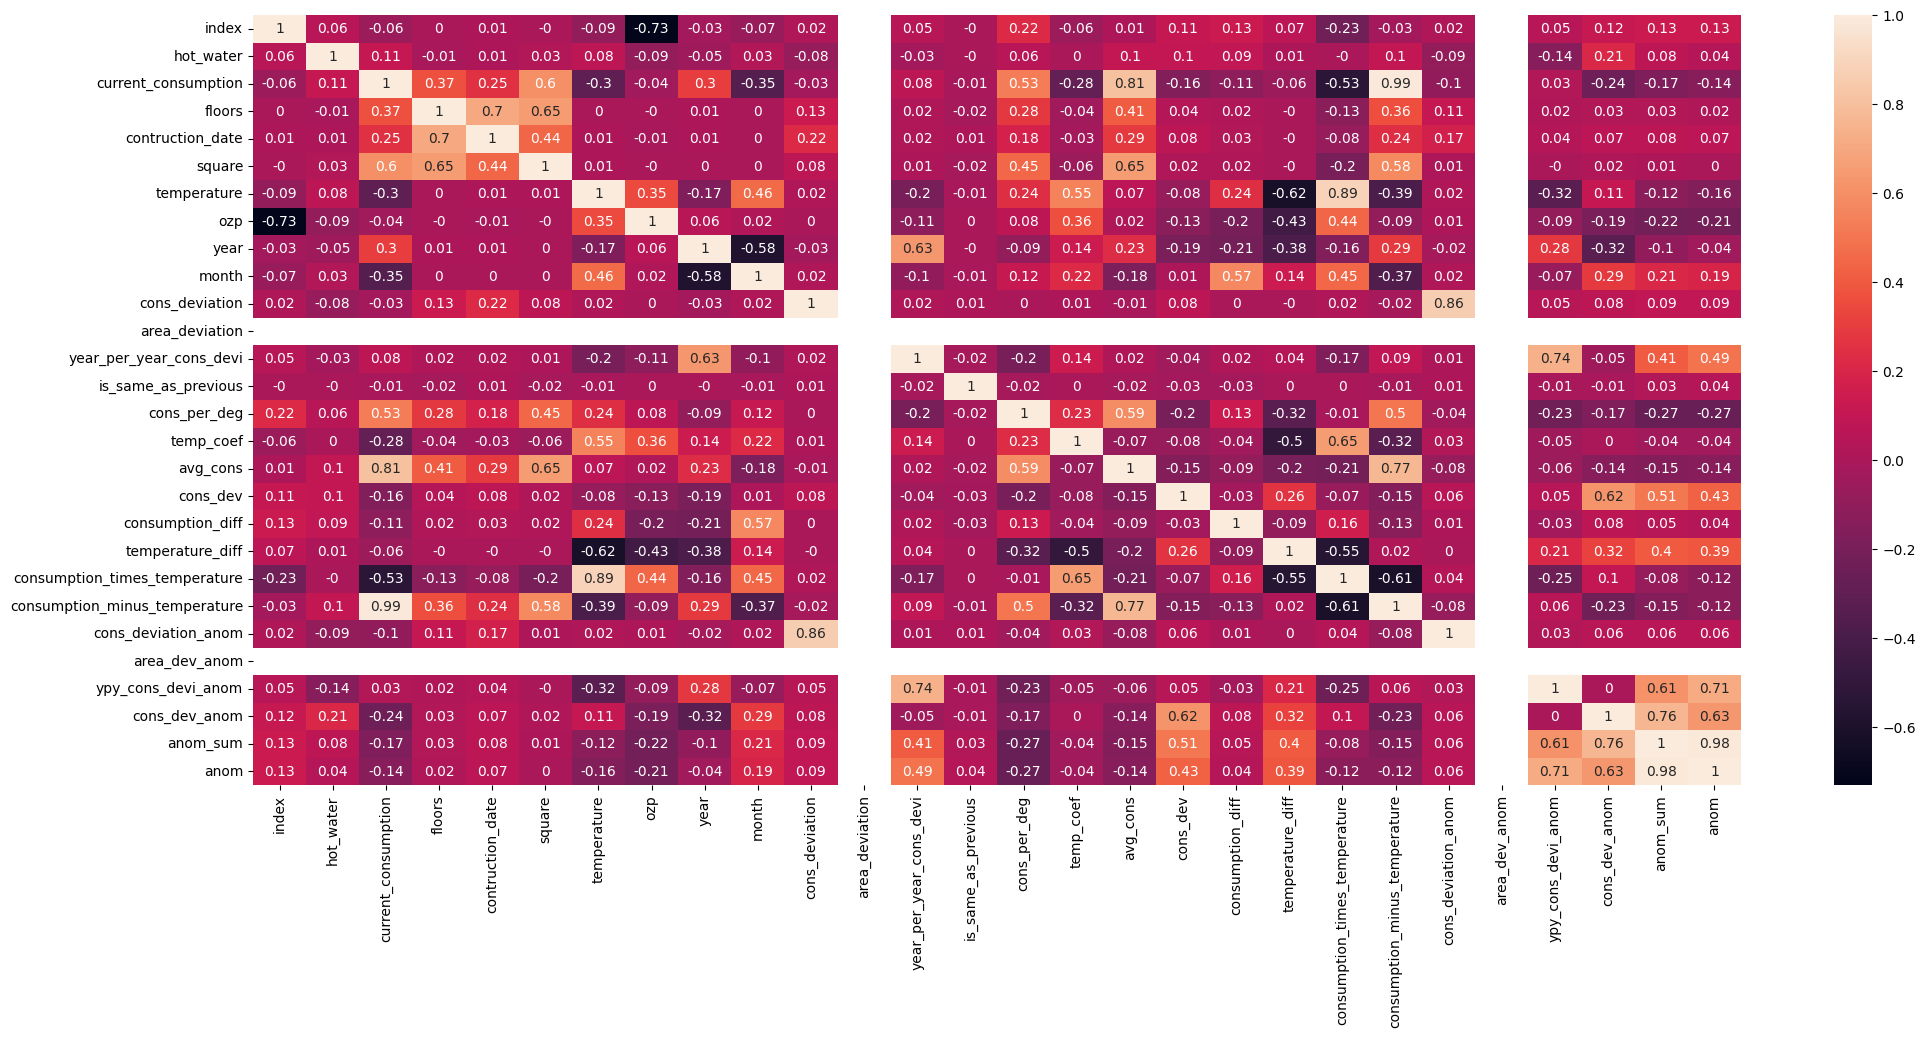

In [26]:
fig, axes = plt.subplots(figsize=(24, 10))
sns.heatmap(round(data_df.corr(method='spearman'), 2), annot=True)

Посмотрим на нормальность признаков

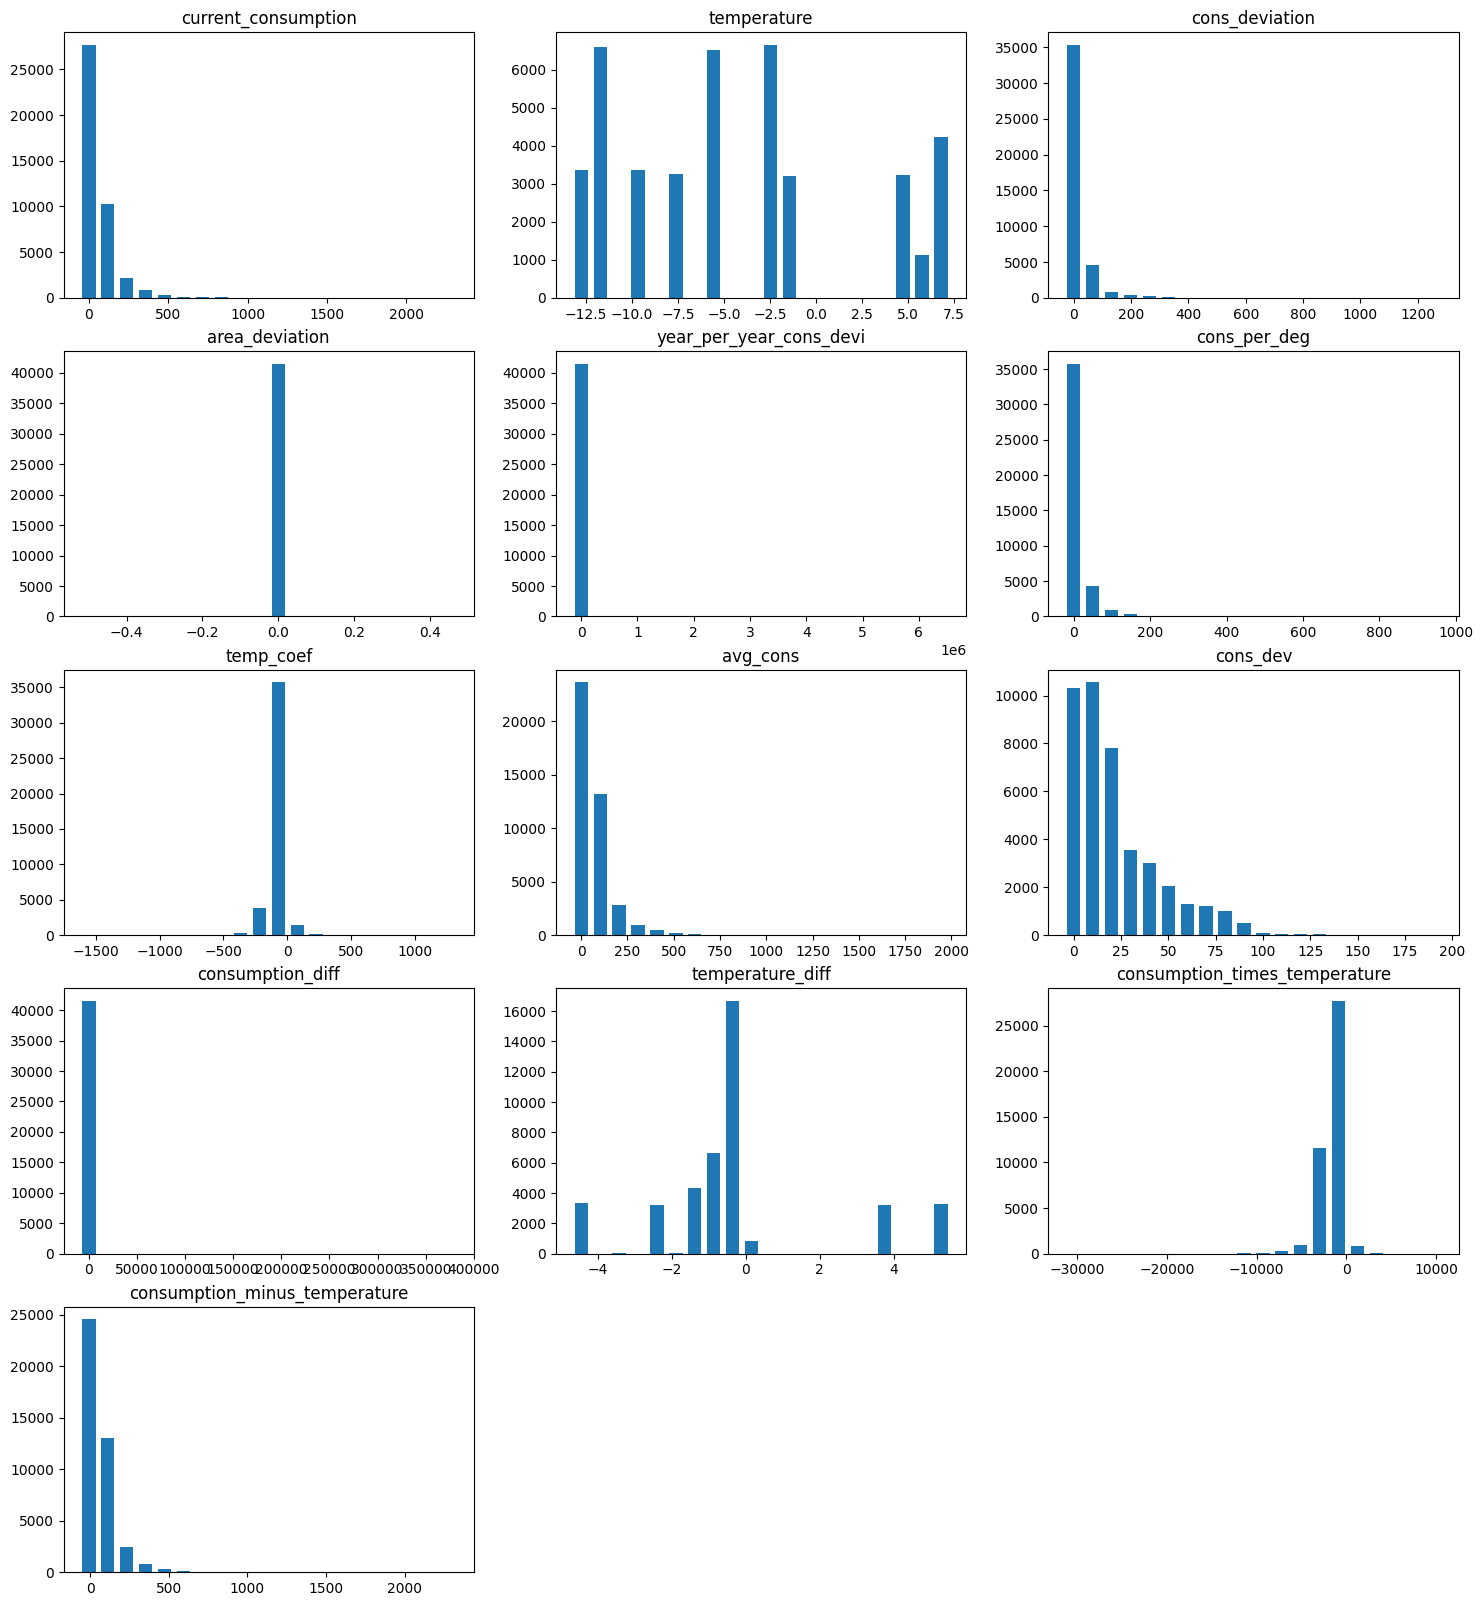

In [5]:
def visnormaldistrib(values):
  columns = min(3, len(values))
  rows = (len(values) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(values.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()
  
visnormaldistrib({'current_consumption': data_df['current_consumption'], 
                  'temperature': data_df['temperature'],'cons_deviation': data_df['cons_deviation'],
                  'area_deviation': data_df['area_deviation'],'year_per_year_cons_devi': data_df['year_per_year_cons_devi'],
                  'cons_per_deg': data_df['cons_per_deg'],'temp_coef': data_df['temp_coef'],'avg_cons': data_df['avg_cons'],'cons_dev': data_df['cons_dev'],
                  'consumption_diff': data_df['consumption_diff'],'temperature_diff': data_df['temperature_diff'],'consumption_times_temperature': data_df['consumption_times_temperature'],
                  'consumption_minus_temperature': data_df['consumption_minus_temperature']})

Данные разряженные с большим колличеством выбросов, для нормализации лучше использовать RobustScaler. Приобразовывать категориальные признаки будем LabelEncoder

In [ ]:
categorical_features = data_df.select_dtypes(include=['object', 'category']).columns.tolist()


label_encoders = {feature: LabelEncoder() for feature in categorical_features}

for feature, le in label_encoders.items():
    data_df[feature] = le.fit_transform(data_df[feature])

In [ ]:
scaler = RobustScaler()
df = pd.DataFrame(scaler.fit_transform(data_df), columns=data_df.columns)

### Обучение моделей

Распределение аномальных значений по типам объектов отличается. 'Многоквартирный дом' наиболее представленый тип объекта, разделим датафрейм на два и обучим две модели.

In [164]:
mask = (~df.address.str.contains('Подобъект|Подъезд')) & (df.object_type == 'Многоквартирный дом')

In [161]:
df_mkd = df[mask]

In [165]:
df_other = df[~mask]

Text(0, 0.5, 'Frequency')

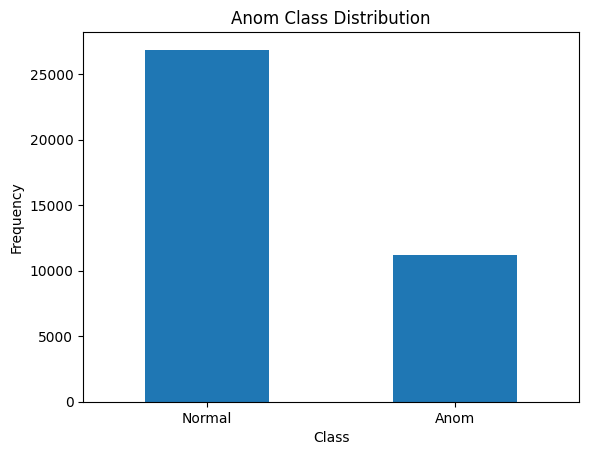

In [319]:
LABELS = ["Normal", "Anom"]

count_classes = pd.value_counts(df_mkd['anom'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Anom Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

Нами было опробованно несколько моделей:IsolatreForest, XGBoost, RandomForest, LSTM, xLSTM. Лучшие результаты показала LSTM 3 слойная с регуляризацией и батчнормализация.

In [ ]:
gpu_strategy = tf.distribute.get_strategy()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# MKD (датасет с многоквартирными домами)

In [ ]:
data_normalized = pd.read_csv('_TMP/combined_4_mkd_normR.csv')

In [ ]:
data_df['anom'] = data_df['anom'].astype(int)

In [ ]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length, :-1]  # Исключаем последний столбец (метку аномалии)
        y = data[i+seq_length, -1]     # Метка аномалии
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 50  # Длина временного окна
X, y = create_sequences(data_normalized.values, seq_length)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## LSTM 1L updated

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])

model_1l = Sequential()
model_1l.add(Input(shape=input_shape))
model_1l.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))
model_1l.add(BatchNormalization())
model_1l.add(Dropout(0.3))

model_1l.add(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001)))
model_1l.add(BatchNormalization())
model_1l.add(Dropout(0.3))

model_1l.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model_1l.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
model_1l.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model_1l.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 50, 128)             │          84,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 50, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 137,281 (536.25 KB)

 Trainable params: 136,897 (534.75 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
history_model_1l = model_1l.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.7795 - loss: 0.6846 - val_accuracy: 0.8760 - val_loss: 0.4341
Epoch 2/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8712 - loss: 0.4259 - val_accuracy: 0.8776 - val_loss: 0.3666
Epoch 3/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8746 - loss: 0.3677 - val_accuracy: 0.8839 - val_loss: 0.3411
Epoch 4/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8787 - loss: 0.3398 - val_accuracy: 0.8836 - val_loss: 0.3239
Epoch 5/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8810 - loss: 0.3204 - val_accuracy: 0.8766 - val_loss: 0.3271
Epoch 6/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8864 - loss: 0.3130 - val_accuracy: 0.8826 - val_loss: 0.3229
Epoch 7/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8808 - loss: 0.3115 - val_accuracy: 0.8911 - val_loss: 0.3066
Epoch 8/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8842 - loss: 0.3042 - va

In [ ]:
y_pred_model_1l = model_1l.predict(X_test)
y_pred_model_1l = (y_pred_model_1l > 0.5).astype(int)

print(classification_report(y_test, y_pred_model_1l))


f1 = f1_score(y_test, y_pred_model_1l)
print(f'F1 Score: {f1}')

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93      5411
         1.0       0.84      0.80      0.82      2188

    accuracy                           0.90      7599
   macro avg       0.88      0.87      0.88      7599
weighted avg       0.90      0.90      0.90      7599

F1 Score: 0.8219626168224299


In [ ]:
# model_1l normalize Robust in colab
#               precision    recall  f1-score   support

#          0.0       0.92      0.94      0.93      5411
#          1.0       0.84      0.80      0.82      2188

#     accuracy                           0.90      7599
#    macro avg       0.88      0.87      0.88      7599
# weighted avg       0.90      0.90      0.90      7599

# F1 Score: 0.8219626168224299

# model_1l normalize MMS in colab

#               precision    recall  f1-score   support

#          0.0       0.92      0.92      0.92      5411
#          1.0       0.80      0.80      0.80      2188

#     accuracy                           0.88      7599
#    macro avg       0.86      0.86      0.86      7599
# weighted avg       0.89      0.88      0.88      7599

# model_1l F1 Score: 0.8006379585326954


# ________________________________________________________
# model_1l normalize robust out colab

#               precision    recall  f1-score   support

#          0.0       0.88      0.89      0.89      5411
#          1.0       0.72      0.70      0.71      2188

#     accuracy                           0.84      7599
#    macro avg       0.80      0.80      0.80      7599
# weighted avg       0.84      0.84      0.84      7599

# F1 Score: 0.7122969837587007
# model_1l normalize mms out colab
#               precision    recall  f1-score   support

#          0.0       0.83      0.92      0.87      5411
#          1.0       0.72      0.54      0.62      2188

#     accuracy                           0.81      7599
#    macro avg       0.78      0.73      0.74      7599
# weighted avg       0.80      0.81      0.80      7599

# F1 Score: 0.6157079064880483

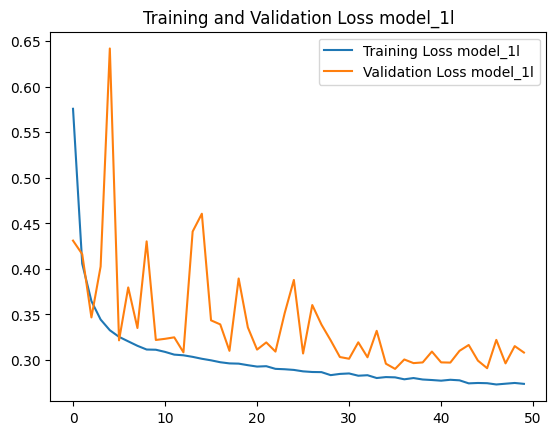

In [ ]:
plt.plot(history_model_1l.history['loss'], label='Training Loss model_1l')
plt.plot(history_model_1l.history['val_loss'], label='Validation Loss model_1l')
plt.legend()
plt.title('Training and Validation Loss model_1l')
plt.show()

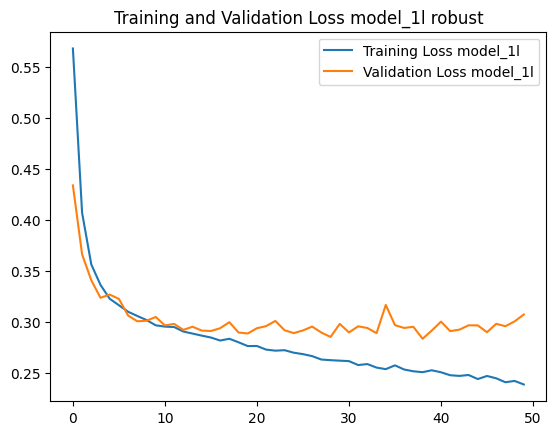

In [ ]:
plt.plot(history_model_1l.history['loss'], label='Training Loss model_1l')
plt.plot(history_model_1l.history['val_loss'], label='Validation Loss model_1l')
plt.legend()
plt.title('Training and Validation Loss model_1l robust')
plt.show()

In [ ]:
feature_names = data_df.columns.tolist()

# Получаем веса первого слоя
weights = model_1l.layers[0].get_weights()[0]

# Вычисляем абсолютные значения весов
abs_weights = np.abs(weights)

# Сортируем признаки по абсолютным значениям весов
feature_importance = np.sum(abs_weights, axis=1)
sorted_indices = np.argsort(feature_importance)[::-1]

# Выводим наиболее значимые признаки
for i in sorted_indices:
    print(f"Признак {feature_names[i]}: Важность {feature_importance[i]}")

Признак consumption_diff: Важность 30.56829833984375
Признак year_per_year_cons_devi: Важность 29.049060821533203
Признак ozp: Важность 22.452747344970703
Признак temp_coef: Важность 22.358470916748047
Признак temperature_diff: Важность 21.465402603149414
Признак cons_per_deg: Важность 20.534229278564453
Признак cons_deviation: Важность 20.09578514099121
Признак cons_dev: Важность 20.00164222717285
Признак num_odpu: Важность 18.02395248413086
Признак floors: Важность 17.930286407470703
Признак const_date_group: Важность 17.926565170288086
Признак anom_sum: Важность 17.5078182220459
Признак street: Важность 17.438840866088867
Признак object_type: Важность 17.06220245361328
Признак consumption_times_temperature: Важность 17.051029205322266
Признак avg_cons: Важность 15.677690505981445
Признак house: Важность 15.448862075805664
Признак building: Важность 15.445594787597656
Признак temperature: Важность 15.372724533081055
Признак floors_group: Важность 14.680766105651855
Признак cons_devia

In [ ]:
model_1l.save('lstm_nornRUp_anomaly_detection_model.keras')

## LSTM 2L updated

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])

model_2l = Sequential()
model_2l.add(Input(shape=input_shape))
model_2l.add(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.001)))
model_2l.add(BatchNormalization())
model_2l.add(Dropout(0.3))

model_2l.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))
model_2l.add(BatchNormalization())
model_2l.add(Dropout(0.3))

model_2l.add(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001)))
model_2l.add(BatchNormalization())
model_2l.add(Dropout(0.3))

model_2l.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model_2l.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
model_2l.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model_2l.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                       │ (None, 50, 256)             │         301,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 50, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 50, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 50, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 50, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 551,489 (2.10 MB)

 Trainable params: 550,593 (2.10 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
history_model_2l = model_2l.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.6883 - loss: 1.1334 - val_accuracy: 0.8711 - val_loss: 0.5782
Epoch 2/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.8677 - loss: 0.5456 - val_accuracy: 0.8704 - val_loss: 0.4235
Epoch 3/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.8698 - loss: 0.4110 - val_accuracy: 0.8615 - val_loss: 0.3802
Epoch 4/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.8790 - loss: 0.3551 - val_accuracy: 0.8836 - val_loss: 0.3456
Epoch 5/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.8776 - loss: 0.3439 - val_accuracy: 0.8888 - val_loss: 0.3315
Epoch 6/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.8785 - loss: 0.3330 - val_accuracy: 0.8783 - val_loss: 0.3309
Epoch 7/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.8777 - loss: 0.3300 - val_accuracy: 0.8839 - val_loss: 0.3205
Epoch 8/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.8844 - loss: 0.3196 - 

In [ ]:
y_pred_model_2l = model_2l.predict(X_test)
y_pred_model_2l = (y_pred_model_2l > 0.5).astype(int)

print(classification_report(y_test, y_pred_model_2l))


f1 = f1_score(y_test, y_pred_model_2l)
print(f'F1 Score: {f1}')

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93      5411
         1.0       0.85      0.79      0.82      2188

    accuracy                           0.90      7599
   macro avg       0.88      0.87      0.88      7599
weighted avg       0.90      0.90      0.90      7599

F1 Score: 0.819966879583629


In [ ]:
# model_2l normalize robust in colab
#               precision    recall  f1-score   support

#          0.0       0.92      0.94      0.93      5411
#          1.0       0.85      0.79      0.82      2188

#     accuracy                           0.90      7599
#    macro avg       0.88      0.87      0.88      7599
# weighted avg       0.90      0.90      0.90      7599

# F1 Score: 0.819966879583629

# model_2l normalize MMS in colab
#              precision    recall  f1-score   support

#          0.0       0.92      0.89      0.91      5411
#          1.0       0.75      0.82      0.78      2188

#     accuracy                           0.87      7599
#    macro avg       0.84      0.85      0.84      7599
# weighted avg       0.87      0.87      0.87      7599

# F1 Score: 0.7811816192560175

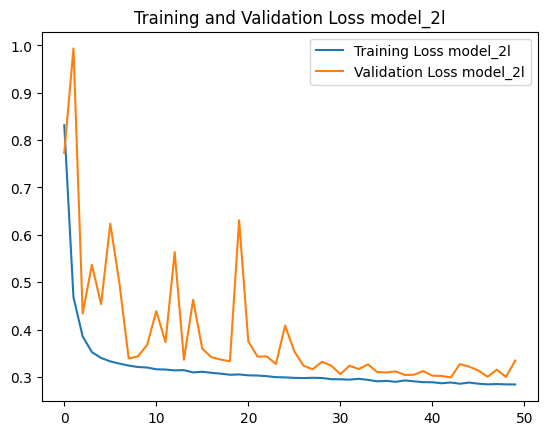

In [ ]:
plt.plot(history_model_2l.history['loss'], label='Training Loss model_2l')
plt.plot(history_model_2l.history['val_loss'], label='Validation Loss model_2l')
plt.legend()
plt.title('Training and Validation Loss model_2l')
plt.show()

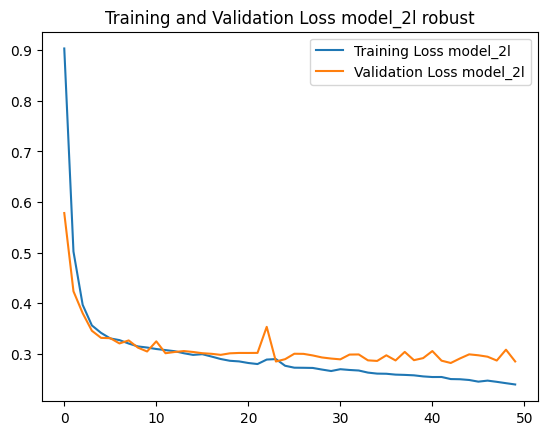

In [ ]:
plt.plot(history_model_2l.history['loss'], label='Training Loss model_2l')
plt.plot(history_model_2l.history['val_loss'], label='Validation Loss model_2l')
plt.legend()
plt.title('Training and Validation Loss model_2l robust')
plt.show()

In [ ]:
feature_names = data_df.columns.tolist()

# Получаем веса первого слоя
weights = model_2l.layers[0].get_weights()[0]

# Вычисляем абсолютные значения весов
abs_weights = np.abs(weights)

# Сортируем признаки по абсолютным значениям весов
feature_importance = np.sum(abs_weights, axis=1)
sorted_indices = np.argsort(feature_importance)[::-1]

# Выводим наиболее значимые признаки
for i in sorted_indices:
    print(f"Признак {feature_names[i]}: Важность {feature_importance[i]}")

Признак year_per_year_cons_devi: Важность 43.90327453613281
Признак consumption_diff: Важность 43.7629508972168
Признак temperature_diff: Важность 31.047372817993164
Признак cons_per_deg: Важность 30.675554275512695
Признак temp_coef: Важность 30.1844482421875
Признак cons_deviation: Важность 29.563478469848633
Признак ozp: Важность 28.917896270751953
Признак floors: Важность 27.264080047607422
Признак consumption_times_temperature: Важность 27.08829116821289
Признак const_date_group: Важность 26.5369930267334
Признак avg_cons: Важность 25.41154670715332
Признак cons_dev: Важность 23.677322387695312
Признак current_consumption: Важность 23.24712371826172
Признак consumption_minus_temperature: Важность 22.857269287109375
Признак street: Важность 22.366525650024414
Признак object_type: Важность 22.353012084960938
Признак anom_sum: Важность 21.91779327392578
Признак num_odpu: Важность 21.62386703491211
Признак floors_group: Важность 20.027423858642578
Признак house: Важность 19.8054733276

In [ ]:
model_2l.save('lstm_2L_nornRUp_anomaly_detection_model.keras')

## Сравнение

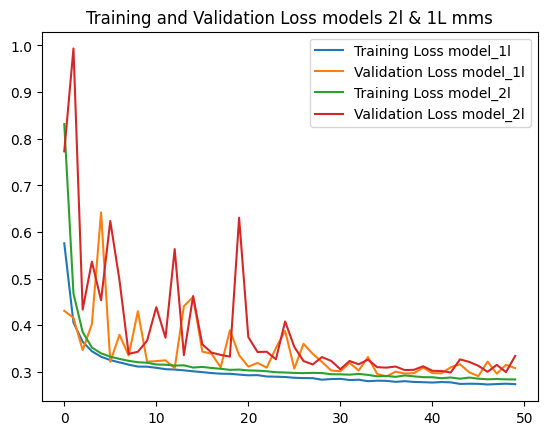

In [ ]:
plt.plot(history_model_1l.history['loss'], label='Training Loss model_1l')
plt.plot(history_model_1l.history['val_loss'], label='Validation Loss model_1l')
plt.plot(history_model_2l.history['loss'], label='Training Loss model_2l')
plt.plot(history_model_2l.history['val_loss'], label='Validation Loss model_2l')

plt.legend()
plt.title('Training and Validation Loss models 2l & 1L mms')
plt.show()

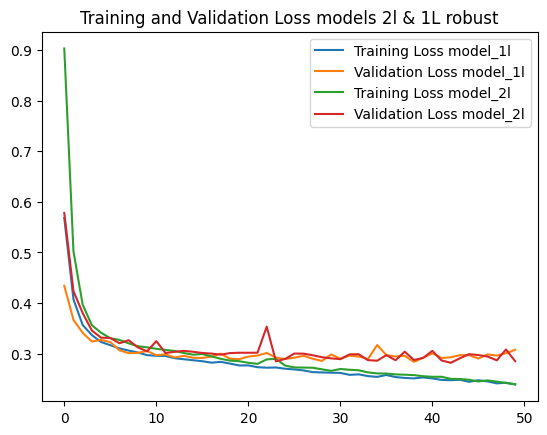

In [ ]:
plt.plot(history_model_1l.history['loss'], label='Training Loss model_1l')
plt.plot(history_model_1l.history['val_loss'], label='Validation Loss model_1l')
plt.plot(history_model_2l.history['loss'], label='Training Loss model_2l')
plt.plot(history_model_2l.history['val_loss'], label='Validation Loss model_2l')

plt.legend()
plt.title('Training and Validation Loss models 2l & 1L robust')
plt.show()

# Датасет с где "все остальное"

In [ ]:
data_normalized = pd.read_csv('_TMP/combined_4_other_normR.csv')

In [ ]:
seq_length = 50  # Длина временного окна
X, y = create_sequences(data_normalized.values, seq_length)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## LSTM 1L updated

In [ ]:
input_shapeO = (X_train.shape[1], X_train.shape[2])

model_1lO = Sequential()
model_1lO.add(Input(shape=input_shapeO))
model_1lO.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))
model_1lO.add(BatchNormalization())
model_1lO.add(Dropout(0.3))

model_1lO.add(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001)))
model_1lO.add(BatchNormalization())
model_1lO.add(Dropout(0.3))

model_1lO.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model_1lO.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
model_1lO.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model_1lO.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                       │ (None, 50, 128)             │          84,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 50, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 137,281 (536.25 KB)

 Trainable params: 136,897 (534.75 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
history_model_1lO = model_1l.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7653 - loss: 0.5641 - val_accuracy: 0.8176 - val_loss: 0.4456
Epoch 2/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8007 - loss: 0.4503 - val_accuracy: 0.8319 - val_loss: 0.4340
Epoch 3/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8210 - loss: 0.4247 - val_accuracy: 0.8166 - val_loss: 0.4284
Epoch 4/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8224 - loss: 0.4230 - val_accuracy: 0.8309 - val_loss: 0.4404
Epoch 5/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8316 - loss: 0.4051 - val_accuracy: 0.8214 - val_loss: 0.4412
Epoch 6/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8434 - loss: 0.3942 - val_accuracy: 0.8157 - val_loss: 0.4584
Epoch 7/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8549 - loss: 0.3720 - val_accuracy: 0.8157 - val_loss: 0.4565
Epoch 8/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8491 - loss: 0.3789 - val_accu

In [ ]:
y_pred_model_1lO = model_1lO.predict(X_test)
y_pred_model_1lO = (y_pred_model_1lO > 0.5).astype(int)

print(classification_report(y_test, y_pred_model_1lO))


f1 = f1_score(y_test, y_pred_model_1lO)
print(f'F1 Score: {f1}')

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
              precision    recall  f1-score   support

         0.0       0.56      0.77      0.65      1460
         1.0       0.46      0.24      0.31      1157

    accuracy                           0.54      2617
   macro avg       0.51      0.51      0.48      2617
weighted avg       0.52      0.54      0.50      2617

F1 Score: 0.3132803632236095


In [ ]:
# model_1lO normolized roobust in colab
#               precision    recall  f1-score   support

#          0.0       0.56      0.77      0.65      1460
#          1.0       0.46      0.24      0.31      1157

#     accuracy                           0.54      2617
#    macro avg       0.51      0.51      0.48      2617
# weighted avg       0.52      0.54      0.50      2617

# F1 Score: 0.3132803632236095

# model_1lO normolized mms in colab
#               precision    recall  f1-score   support

#          0.0       0.49      0.11      0.18      1460
#          1.0       0.43      0.85      0.57      1157

#     accuracy                           0.44      2617
#    macro avg       0.46      0.48      0.38      2617
# weighted avg       0.46      0.44      0.36      2617

# F1 Score: 0.5723435225618632

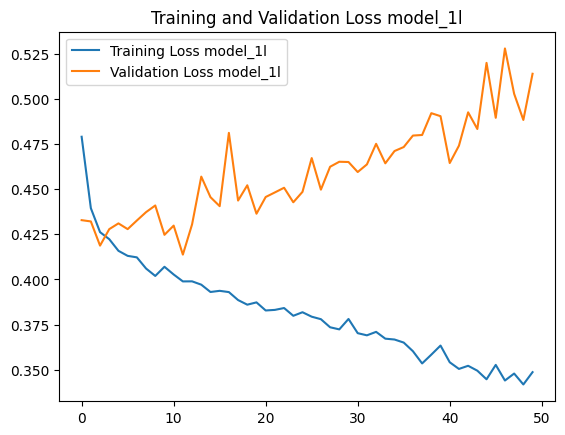

In [ ]:
plt.plot(history_model_1lO.history['loss'], label='Training Loss model_1l')
plt.plot(history_model_1lO.history['val_loss'], label='Validation Loss model_1l')
plt.legend()
plt.title('Training and Validation Loss model_1lO')
plt.show()

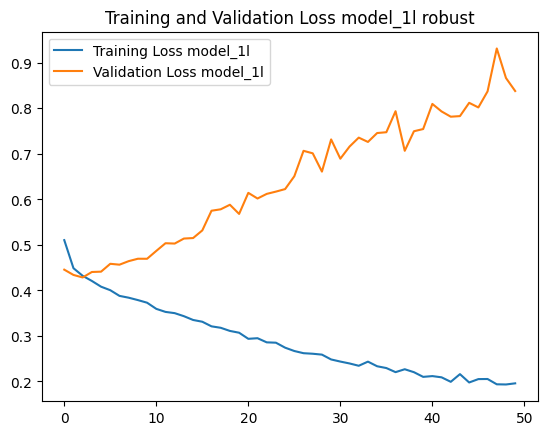

In [ ]:
plt.plot(history_model_1lO.history['loss'], label='Training Loss model_1l')
plt.plot(history_model_1lO.history['val_loss'], label='Validation Loss model_1l')
plt.legend()
plt.title('Training and Validation Loss model_1l robust')
plt.show()

In [ ]:
feature_names = data_df.columns.tolist()

# Получаем веса первого слоя
weights = model_1lO.layers[0].get_weights()[0]

# Вычисляем абсолютные значения весов
abs_weights = np.abs(weights)

# Сортируем признаки по абсолютным значениям весов
feature_importance = np.sum(abs_weights, axis=1)
sorted_indices = np.argsort(feature_importance)[::-1]

# Выводим наиболее значимые признаки
for i in sorted_indices:
    print(f"Признак {feature_names[i]}: Важность {feature_importance[i]}")

Признак cons_per_deg: Важность 28.543954849243164
Признак ypy_cons_devi_anom: Важность 28.19029998779297
Признак area_deviation: Важность 27.911537170410156
Признак cons_deviation_anom: Важность 27.714317321777344
Признак house: Важность 27.631771087646484
Признак contruction_date: Важность 27.25759506225586
Признак index: Важность 27.102821350097656
Признак avg_cons: Важность 27.08985710144043
Признак year_per_year_cons_devi: Важность 27.065248489379883
Признак const_date_group: Важность 27.018821716308594
Признак current_consumption: Важность 26.98902702331543
Признак consumption_times_temperature: Важность 26.869503021240234
Признак square: Важность 26.862751007080078
Признак anom_sum: Важность 26.801250457763672
Признак cons_deviation: Важность 26.733901977539062
Признак temp_coef: Важность 26.637928009033203
Признак consumption_diff: Важность 26.593530654907227
Признак month: Важность 26.571727752685547
Признак cons_dev_anom: Важность 26.54741096496582
Признак temperature_diff: Ва

In [ ]:
# model_1lO.save('lstm_OTHER_1L_normMmsUp_anomaly_detection_model.keras')
model_1lO.save('lstm_OTHER_1L_nornRUp_anomaly_detection_model.keras')

## LSTM 2L updated

In [ ]:
input_shapeO = (X_train.shape[1], X_train.shape[2])

model_2lO = Sequential()
model_2lO.add(Input(shape=input_shapeO))
model_2lO.add(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.001)))
model_2lO.add(BatchNormalization())
model_2lO.add(Dropout(0.3))

model_2lO.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))
model_2lO.add(BatchNormalization())
model_2lO.add(Dropout(0.3))

model_2lO.add(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001)))
model_2lO.add(BatchNormalization())
model_2lO.add(Dropout(0.3))

model_2lO.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model_2lO.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
model_2lO.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model_2lO.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                       │ (None, 50, 256)             │         301,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 50, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 50, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ (None, 50, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 50, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 551,489 (2.10 MB)

 Trainable params: 550,593 (2.10 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
history_model_2lO = model_2l.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7522 - loss: 0.5986 - val_accuracy: 0.8032 - val_loss: 0.4547
Epoch 2/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8055 - loss: 0.4580 - val_accuracy: 0.8166 - val_loss: 0.4427
Epoch 3/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8170 - loss: 0.4343 - val_accuracy: 0.8138 - val_loss: 0.4524
Epoch 4/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8331 - loss: 0.4135 - val_accuracy: 0.8176 - val_loss: 0.4474
Epoch 5/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8293 - loss: 0.4142 - val_accuracy: 0.8147 - val_loss: 0.4467
Epoch 6/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8349 - loss: 0.4057 - val_accuracy: 0.8223 - val_loss: 0.4472
Epoch 7/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8440 - loss: 0.3968 - val_accuracy: 0.8214 - val_loss: 0.4547
Epoch 8/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8514 - loss: 0.3791 - val_acc

In [ ]:
y_pred_model_2lO = model_2lO.predict(X_test)
y_pred_model_2lO = (y_pred_model_2lO > 0.5).astype(int)

print(classification_report(y_test, y_pred_model_2lO))


f1 = f1_score(y_test, y_pred_model_2lO)
print(f'F1 Score: {f1}')

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
              precision    recall  f1-score   support

         0.0       0.56      0.09      0.16      1460
         1.0       0.44      0.91      0.60      1157

    accuracy                           0.45      2617
   macro avg       0.50      0.50      0.38      2617
weighted avg       0.51      0.45      0.35      2617

F1 Score: 0.5950226244343891


In [ ]:
#model_2lO normolized robust in colab
#               precision    recall  f1-score   support

#          0.0       0.56      0.09      0.16      1460
#          1.0       0.44      0.91      0.60      1157

#     accuracy                           0.45      2617
#    macro avg       0.50      0.50      0.38      2617
# weighted avg       0.51      0.45      0.35      2617

# F1 Score: 0.5950226244343891

#model_2lO normolized mms in colab
#               precision    recall  f1-score   support

#          0.0       0.56      1.00      0.72      1460
#          1.0       1.00      0.00      0.00      1157

#     accuracy                           0.56      2617
#    macro avg       0.78      0.50      0.36      2617
# weighted avg       0.75      0.56      0.40      2617

# F1 Score: 0.003451251078515962

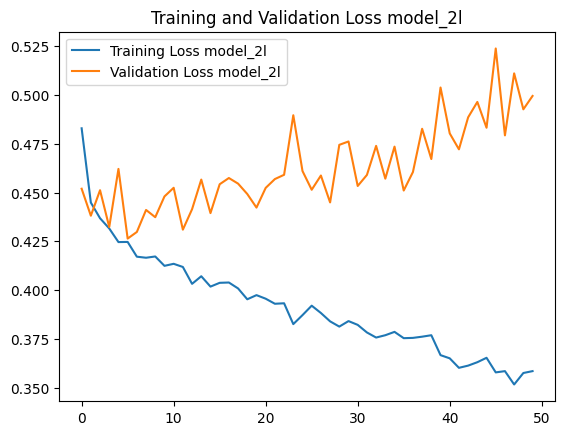

In [ ]:
plt.plot(history_model_2lO.history['loss'], label='Training Loss model_2l')
plt.plot(history_model_2lO.history['val_loss'], label='Validation Loss model_2l')
plt.legend()
plt.title('Training and Validation Loss model_2l')
plt.show()

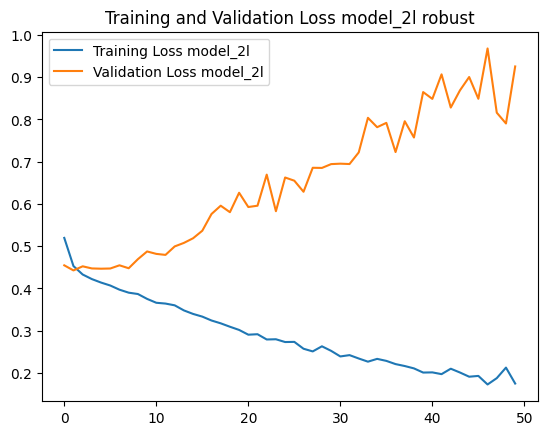

In [ ]:
plt.plot(history_model_2lO.history['loss'], label='Training Loss model_2l')
plt.plot(history_model_2lO.history['val_loss'], label='Validation Loss model_2l')
plt.legend()
plt.title('Training and Validation Loss model_2l robust')
plt.show()

In [ ]:
feature_names = data_df.columns.tolist()

# Получаем веса первого слоя
weights = model_2lO.layers[0].get_weights()[0]

# Вычисляем абсолютные значения весов
abs_weights = np.abs(weights)

# Сортируем признаки по абсолютным значениям весов
feature_importance = np.sum(abs_weights, axis=1)
sorted_indices = np.argsort(feature_importance)[::-1]

# Выводим наиболее значимые признаки
for i in sorted_indices:
    print(f"Признак {feature_names[i]}: Важность {feature_importance[i]}")

Признак ozp: Важность 39.858245849609375
Признак street: Важность 39.690425872802734
Признак hot_water: Важность 39.336631774902344
Признак ypy_cons_devi_anom: Важность 39.31925964355469
Признак division: Важность 39.26447296142578
Признак consumption_times_temperature: Важность 39.150604248046875
Признак num_odpu: Важность 39.089744567871094
Признак house: Важность 39.04716491699219
Признак temperature_diff: Важность 38.98569107055664
Признак avg_cons: Важность 38.86498260498047
Признак consumption_diff: Важность 38.83906936645508
Признак cons_dev_anom: Важность 38.82660675048828
Признак area_deviation: Важность 38.789398193359375
Признак square: Важность 38.739830017089844
Признак month: Важность 38.726478576660156
Признак area_dev_anom: Важность 38.600196838378906
Признак anom_sum: Важность 38.49159622192383
Признак object_type: Важность 38.48766326904297
Признак year_per_year_cons_devi: Важность 38.42723083496094
Признак temp_coef: Важность 38.318119049072266
Признак year: Важность

In [ ]:
# model_2lO.save('lstm_OTHER_2L_normMmsUp_anomaly_detection_model.keras')
model_2lO.save('lstm_OTHER_2L_nornRUp_anomaly_detection_model.keras')

# Simple SLTM

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6292 - loss: 0.6211 - val_accuracy: 0.7880 - val_loss: 0.4487
Epoch 2/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7701 - loss: 0.4638 - val_accuracy: 0.7813 - val_loss: 0.4541
Epoch 3/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7854 - loss: 0.4379 - val_accuracy: 0.7994 - val_loss: 0.4284
Epoch 4/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8086 - loss: 0.4119 - val_accuracy: 0.7918 - val_loss: 0.4302
Epoch 5/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8215 - loss: 0.3883 - val_accuracy: 0.8042 - val_loss: 0.4244
Epoch 6/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8196 - loss: 0.3876 - val_accuracy: 0.7908 - val_loss: 0.4274
Epoch 7/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8434 - loss: 0.3603 - val_accuracy: 0.8052 - val_loss: 0.4264
Epoch 8/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8408 - loss: 0.3474 - val_accurac

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred))
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

         0.0       0.83      0.82      0.82      1460
         1.0       0.77      0.79      0.78      1157

    accuracy                           0.80      2617
   macro avg       0.80      0.80      0.80      2617
weighted avg       0.80      0.80      0.80      2617

F1 Score: 0.7806755023514322


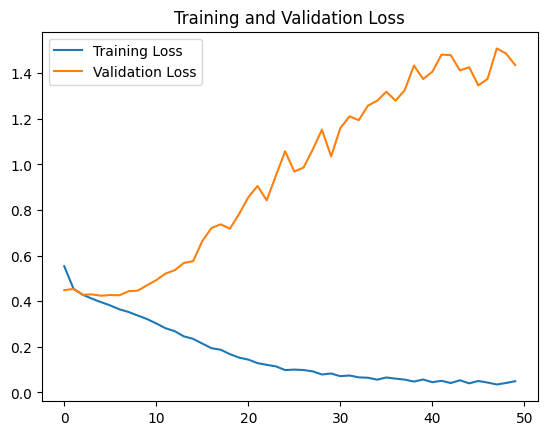

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save('lstm_simple_nornRUp_anomaly_detection_model.keras')

In [ ]:
feature_names = data_df.columns.tolist()

# Получаем веса первого слоя
weights = model.layers[0].get_weights()[0]

# Вычисляем абсолютные значения весов
abs_weights = np.abs(weights)

# Сортируем признаки по абсолютным значениям весов
feature_importance = np.sum(abs_weights, axis=1)
sorted_indices = np.argsort(feature_importance)[::-1]

# Выводим наиболее значимые признаки
for i in sorted_indices:
    print(f"Признак {feature_names[i]}: Важность {feature_importance[i]}")

Признак is_same_as_previous: Важность 110.97113037109375
Признак index: Важность 99.36228942871094
Признак cons_dev: Важность 97.91433715820312
Признак year_per_year_cons_devi: Важность 94.56600189208984
Признак num_odpu: Важность 94.10099792480469
Признак ypy_cons_devi_anom: Важность 93.06256103515625
Признак cons_deviation_anom: Важность 91.27068328857422
Признак consumption_diff: Важность 85.40988159179688
Признак date: Важность 85.20109558105469
Признак ozp: Важность 84.79373168945312
Признак temperature: Важность 81.84037017822266
Признак temperature_diff: Важность 81.60020446777344
Признак cons_dev_anom: Важность 81.44141387939453
Признак year: Важность 81.20064544677734
Признак temp_coef: Важность 79.55963134765625
Признак month: Важность 79.07981872558594
Признак street: Важность 78.97814178466797
Признак cons_deviation: Важность 78.13224792480469
Признак hot_water: Важность 78.06109619140625
Признак square: Важность 74.93728637695312
Признак anom_sum: Важность 72.5916976928711

## Compare

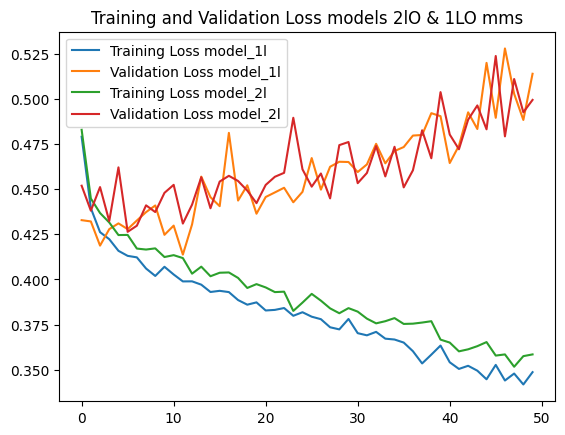

In [ ]:
plt.plot(history_model_1lO.history['loss'], label='Training Loss model_1l')
plt.plot(history_model_1lO.history['val_loss'], label='Validation Loss model_1l')
plt.plot(history_model_2lO.history['loss'], label='Training Loss model_2l')
plt.plot(history_model_2lO.history['val_loss'], label='Validation Loss model_2l')

plt.legend()
plt.title('Training and Validation Loss models 2lO & 1LO mms')
plt.show()

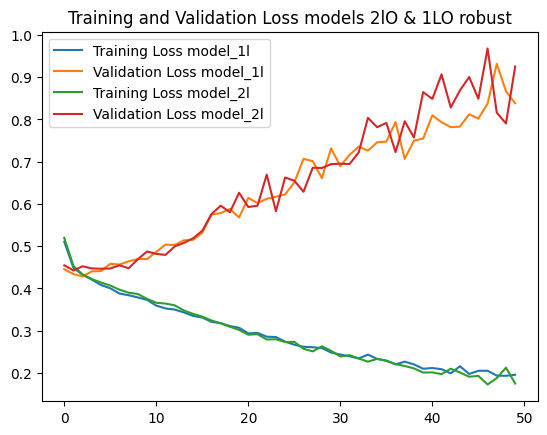

In [ ]:
plt.plot(history_model_1lO.history['loss'], label='Training Loss model_1l')
plt.plot(history_model_1lO.history['val_loss'], label='Validation Loss model_1l')
plt.plot(history_model_2lO.history['loss'], label='Training Loss model_2l')
plt.plot(history_model_2lO.history['val_loss'], label='Validation Loss model_2l')

plt.legend()
plt.title('Training and Validation Loss models 2lO & 1LO robust')
plt.show()

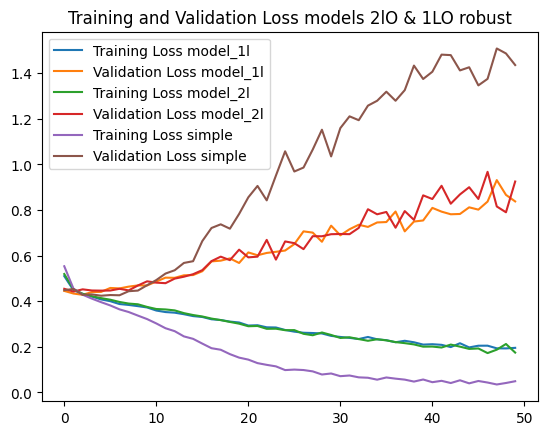

In [ ]:
plt.plot(history_model_1lO.history['loss'], label='Training Loss model_1l')
plt.plot(history_model_1lO.history['val_loss'], label='Validation Loss model_1l')
plt.plot(history_model_2lO.history['loss'], label='Training Loss model_2l')
plt.plot(history_model_2lO.history['val_loss'], label='Validation Loss model_2l')
plt.plot(history.history['loss'], label='Training Loss simple')
plt.plot(history.history['val_loss'], label='Validation Loss simple')
plt.legend()
plt.title('Training and Validation Loss models 2lO & 1LO robust')
plt.show()

# Выгрузка результатов предсказаний

In [ ]:
model.load('lstm_normRUp_anomaly_detection_model.h5') # лучшая модель для многоквартирных домов
# model.load('lstm_simple_nornRUp_anomaly_detection_model.h5') # лучшая модель для всего остального

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred = (y_pred > 0.5).astype(int)  # Преобразуем вероятности в метки классов

In [ ]:
#создаем датафрейм с предсказаниями
y_test_df = pd.DataFrame(y_test, columns=['true_class'])
y_pred_df = pd.DataFrame(y_pred, columns=['predicted_class'])
result_df = pd.concat([y_test_df, y_pred_df], axis=1)

In [ ]:
#Возврат преобразованных категориальных признаков обратно в исходный вид
for feature, le in label_encoders.items():
    df[feature] = le.inverse_transform(df[feature])

In [ ]:
anomalies_df = pd.concat([df.iloc[-len(y_test):].reset_index(), result_df], axis=1)

In [ ]:
anomalies_df.to_excel('anomalies.xlsx',sheet_name='аномалии', index=False)